In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import irfft, rfft, rfftfreq
from scipy.signal import find_peaks

In [2]:
data = pd.read_csv('original_bioradio_1.csv',sep=',') #импорт данных, полученных с BioCapture

In [3]:
data

Elapsed Time  FP1              Fp2  BioRadio Event  \
00:00:00     0   3.583305e+14    0  620372295379639             0.0   
00:00:00.001 3   1.074030e+13    5   38007926940918             0.0   
00:00:00.002 13  5.357037e+12   23     436393737793             0.0   
00:00:00.003 40  4.446449e+12   70     301361083984             0.0   
00:00:00.004 95  6.516266e+11  164     609161376953             0.0   
...                       ...  ...              ...             ...   
00:18:39.835 27  5.903664e+12   21    4300727844238             0.0   
00:18:39.836 25  8.963203e+11   19    3467655181885             0.0   
00:18:39.837 22  6.196136e+12   17    3437519073486             0.0   
00:18:39.838 20  1.966705e+12   15    4193296432495             0.0   
00:18:39.839 17  8.396854e+12   13    5698909759521             0.0   

                 Unnamed: 4  
00:00:00     0          NaN  
00:00:00.001 3          NaN  
00:00:00.002 13         NaN  
00:00:00.003 40         NaN  
00:00:00.004 95         NaN  
...                     ...  
00:18:39.835 27         NaN  
00:18:39.836 25         NaN  
00:18:39.837 22         NaN  
00:18:39.838 20         NaN  
00:18:39.839 17         NaN  

[1119840 rows x 5 columns]

In [4]:
data = data.reset_index()
#удаление ненужных столбцов, переименнование столбцов
data = data.drop(columns=['Elapsed Time','Fp2','BioRadio Event','Unnamed: 4']) \
            .rename(columns={'level_0':'Time','level_1':'Fp1','FP1':'Fp2'})
data

Time  Fp1  Fp2
0            00:00:00    0    0
1        00:00:00.001    3    5
2        00:00:00.002   13   23
3        00:00:00.003   40   70
4        00:00:00.004   95  164
...               ...  ...  ...
1119835  00:18:39.835   27   21
1119836  00:18:39.836   25   19
1119837  00:18:39.837   22   17
1119838  00:18:39.838   20   15
1119839  00:18:39.839   17   13

[1119840 rows x 3 columns]

In [5]:
data = data.set_index('Time')

<AxesSubplot:xlabel='Time'>

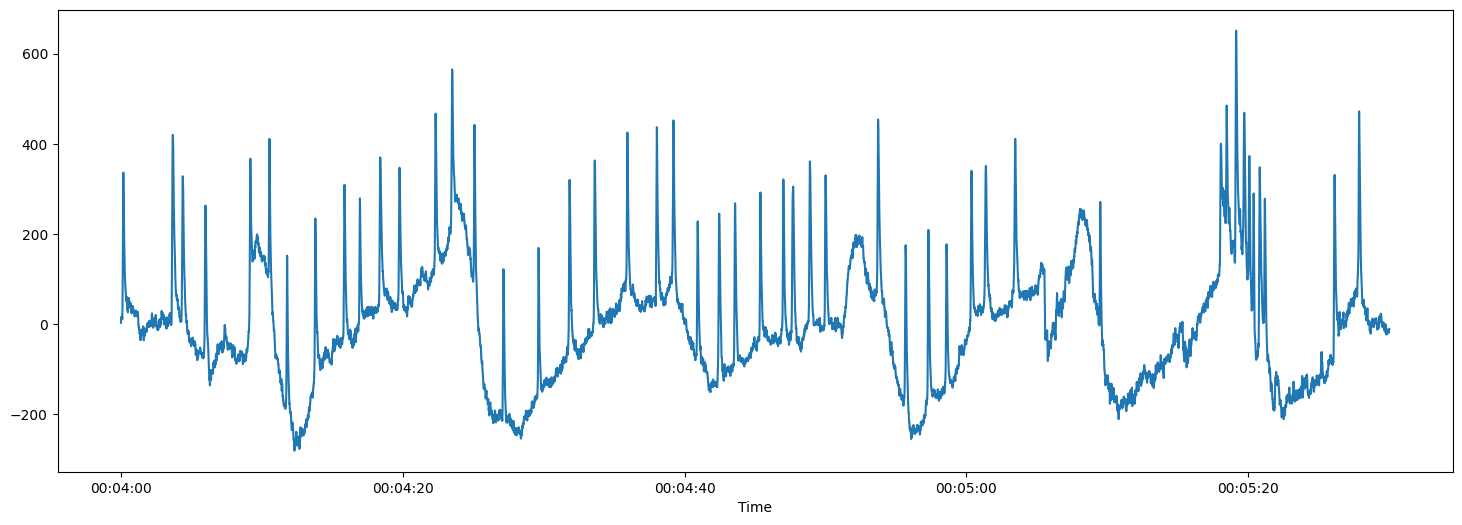

In [6]:
data['Fp1'][240000:330000].plot(figsize=(18,6)) #просмотр данных, видны сигналы ЭОГ

In [7]:
data

Fp1  Fp2
Time                  
00:00:00        0    0
00:00:00.001    3    5
00:00:00.002   13   23
00:00:00.003   40   70
00:00:00.004   95  164
...           ...  ...
00:18:39.835   27   21
00:18:39.836   25   19
00:18:39.837   22   17
00:18:39.838   20   15
00:18:39.839   17   13

[1119840 rows x 2 columns]

Сегментация на эксперименты

In [8]:
data_segment_fp1 = []
data_segment_fp2 = []

In [9]:
count = 11 #количество экспериментов
start_ind = 1000*60*4 #время начало эксперимента
for i in range(count):
    start_ind += 1000*5
    data_segment_fp1.append(data['Fp1'][start_ind:start_ind+1000*60].to_numpy())
    data_segment_fp2.append(data['Fp2'][start_ind:start_ind+1000*60].to_numpy())
    start_ind += 1000*75

In [10]:
data_segment_fp2

[array([-46, -46, -46, ...,  20,  20,  19], dtype=int64),
 array([93, 93, 92, ..., -2, -2, -2], dtype=int64),
 array([-145, -146, -148, ...,   63,   63,   63], dtype=int64),
 array([-5, -6, -6, ..., -8, -8, -7], dtype=int64),
 array([-45, -44, -43, ...,  -6,  -6,  -6], dtype=int64),
 array([-43, -42, -40, ..., -67, -66, -66], dtype=int64),
 array([ -40,  -39,  -38, ..., -207, -207, -207], dtype=int64),
 array([ -67,  -67,  -66, ..., -313, -312, -311], dtype=int64),
 array([ 113,  113,  113, ..., -163, -162, -161], dtype=int64),
 array([ 285,  286,  286, ..., -216, -217, -218], dtype=int64),
 array([  21,   20,   19, ..., -120, -124, -129], dtype=int64)]

In [11]:
len(data_segment_fp1[1])

60000

Удаление аномальных значений

In [12]:
def check_anomaly(arr):
    mean = arr.mean()
    std = arr.std()
    
    low_value = mean - std * 3
    high_value = mean + std * 3
    
    return [elem if elem < high_value and elem > low_value else mean for elem in arr]

In [13]:
data_segment_fp1[1].std()

80.65493250133903

In [14]:
for i in range(len(data_segment_fp1)):
    data_segment_fp1[i] = check_anomaly(data_segment_fp1[i])

for i in range(len(data_segment_fp2)):
    data_segment_fp2[i] = check_anomaly(data_segment_fp2[i])

Удаление EOG

In [15]:
begin_eog = 75
ending_eog = 175

def delete_eog(data,height):    
    for i in range(len(data)):
        peaks, _ = find_peaks(data[i], height=height)
        for elem in peaks:
            start = elem - begin_eog if elem - begin_eog > 0 else 0
            end = elem + ending_eog if elem + ending_eog < len(data[i]) else len(data[i]) -1    
            mean = (data[i][start] + data[i][end])/2
            data[i][start:end] = [mean] * (end-start)
    return data

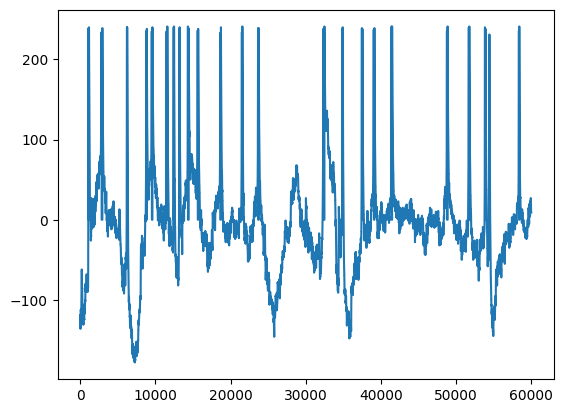

In [16]:
plt.plot(data_segment_fp1[1])
plt.show()

In [17]:
data_segment_fp1 = delete_eog(data_segment_fp1,150)
data_segment_fp2 = delete_eog(data_segment_fp2,150)

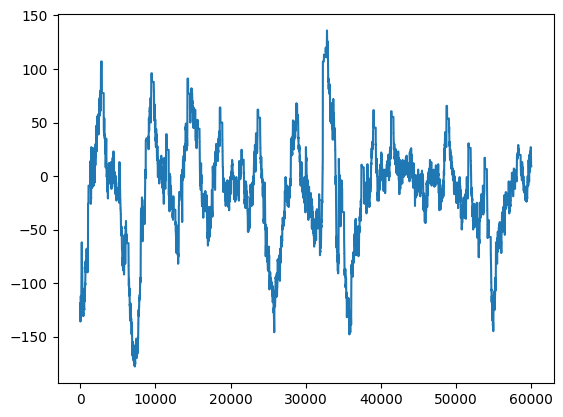

In [18]:
plt.plot(data_segment_fp1[1])
plt.show()

Понижение частоты до 128 HZ

In [25]:
def filt_freq(data):
    ans = []
    for elem in data:
        new_elem = []
        for i in range(0,len(elem),8):
            new_elem.append(np.mean(elem[i:i+8]))
        ans.append(new_elem)
    return ans

In [26]:
data_segment_fp1_128 = filt_freq(data_segment_fp1)    
data_segment_fp2_128 = filt_freq(data_segment_fp2)

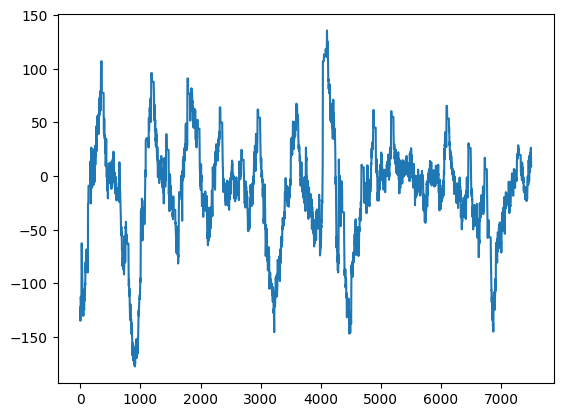

In [27]:
plt.plot(data_segment_fp1_128[1])
plt.show()

Применение полосового фильтра от 4 до 45 HZ

In [29]:
for i in range(len(data_segment_fp1_128)):
    y = rfft(data_segment_fp1_128[i]) # мощность волн определённой частоты на графике
    x = rfftfreq(len(data_segment_fp1_128[i]), 1 / 128)
    
    for ind in range(len(x)):
        if (x[ind] < 4) or (x[ind] > 45):
            y[ind] = 0
    
    data_segment_fp1_128[i] = irfft(y)

for i in range(len(data_segment_fp2_128)):
    y = rfft(data_segment_fp2_128[i]) # мощность волн определённой частоты на графике
    x = rfftfreq(len(data_segment_fp2_128[i]), 1 / 128)
    
    for ind in range(len(x)):
        if (x[ind] < 4) or (x[ind] > 45):
            y[ind] = 0
    
    data_segment_fp2_128[i] = irfft(y)

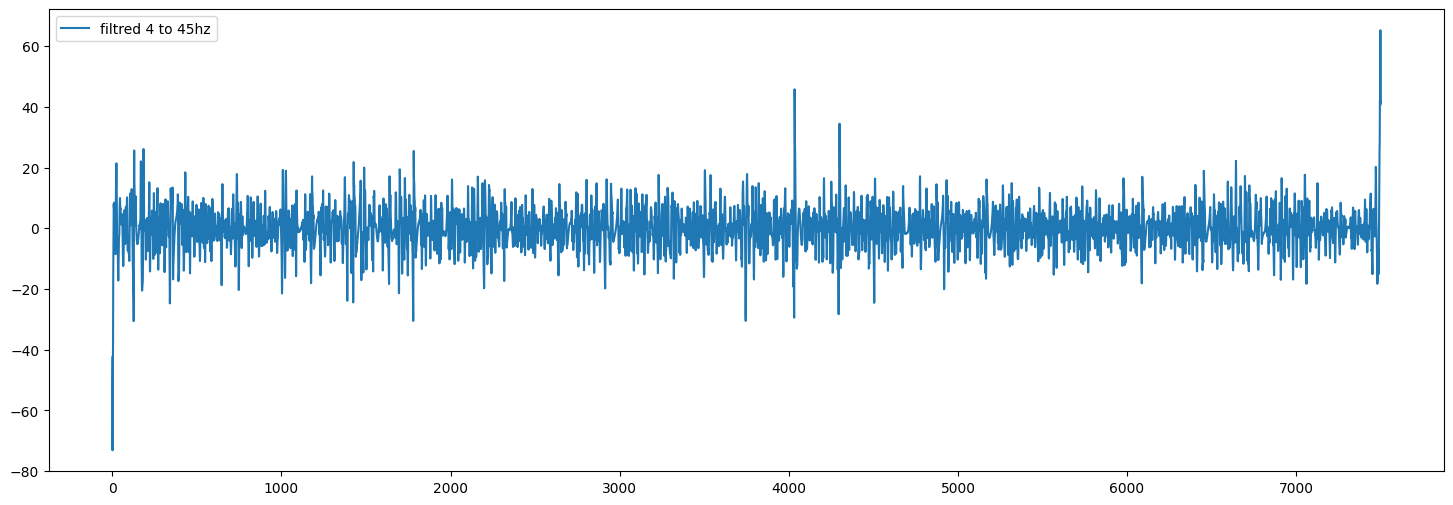

In [30]:
plt.figure(figsize=(18, 6)) 
plt.plot(data_segment_fp1_128[1],label='filtred 4 to 45hz')
plt.legend(loc='best')
plt.show()

In [31]:
len(data_segment_fp1_128[0])

7500

Сохранение предобработки данных

In [32]:
pd.DataFrame(data_segment_fp1_128).to_csv('bioradio_1_fp1.csv')

In [33]:
pd.DataFrame(data_segment_fp2_128).to_csv('bioradio_1_fp2.csv')

Оценки

In [34]:
raitings = pd.DataFrame(columns=['valence','arousal','dominance','liking'])

In [35]:
raitings['valence'] = [7,5,7,2,5,7,8,7,8,5,7]

In [36]:
raitings['arousal'] = [7,7,3,2,7,3,3,2,7,1,5]

In [37]:
raitings['dominance'] = [6,3,6,2,8,3,5,3,5,4,5]

In [38]:
raitings['liking'] = [4,2,3,1,2,1,3,4,4,1,3]

In [39]:
raitings

valence  arousal  dominance  liking
0         7        7          6       4
1         5        7          3       2
2         7        3          6       3
3         2        2          2       1
4         5        7          8       2
5         7        3          3       1
6         8        3          5       3
7         7        2          3       4
8         8        7          5       4
9         5        1          4       1
10        7        5          5       3

In [40]:
valence = []
for elem in raitings['valence']:
    if elem >= 5:
           valence.append(1)
    else:
           valence.append(0)
raitings['valence_model'] = valence

arousal = []
for elem in raitings['arousal']:
    if elem >= 5:
           arousal.append(1)
    else:
           arousal.append(0)
raitings['arousal_model'] = arousal

In [41]:
raitings

valence  arousal  dominance  liking  valence_model  arousal_model
0         7        7          6       4              1              1
1         5        7          3       2              1              1
2         7        3          6       3              1              0
3         2        2          2       1              0              0
4         5        7          8       2              1              1
5         7        3          3       1              1              0
6         8        3          5       3              1              0
7         7        2          3       4              1              0
8         8        7          5       4              1              1
9         5        1          4       1              1              0
10        7        5          5       3              1              1

In [42]:
raitings.to_csv('bioradio_raiting_1.csv')

Обработка 2 участника

In [43]:
data = pd.read_csv('original_bioradio_2.csv',sep=',') #импорт данных, полученных с BioCapture

In [44]:
data

Elapsed Time  FP1           Fp2  BioRadio Event  \
00:00:00      0    603495299816132    0  9.218061e+13             0.0   
00:00:00.001  5     23411464691162    7  9.948912e+13             0.0   
00:00:00.002  22     8027763366699   34  8.304138e+12             0.0   
00:00:00.003  68     1448516845703  104  8.853149e+10             0.0   
00:00:00.004  160     199127197266  244  6.955109e+11             0.0   
...                            ...  ...           ...             ...   
00:21:07.064 -41     2142181396484  -52  6.840210e+12             0.0   
00:21:07.065 -42     9602966308594  -65  3.824310e+12             0.0   
00:21:07.066 -48      166618347168  -82  2.288971e+12             0.0   
00:21:07.067 -56     4670562744141 -101  5.953445e+11             0.0   
00:21:07.068 -67     1237411499023 -121  5.204468e+11             0.0   

                   Unnamed: 4  
00:00:00      0           NaN  
00:00:00.001  5           NaN  
00:00:00.002  22          NaN  
00:00:00.003  68          NaN  
00:00:00.004  160         NaN  
...                       ...  
00:21:07.064 -41          NaN  
00:21:07.065 -42          NaN  
00:21:07.066 -48          NaN  
00:21:07.067 -56          NaN  
00:21:07.068 -67          NaN  

[1267069 rows x 5 columns]

In [45]:
data = data.reset_index()
#удаление ненужных столбцов, переименнование столбцов
data = data.drop(columns=['Elapsed Time','Fp2','BioRadio Event','Unnamed: 4']) \
            .rename(columns={'level_0':'Time','level_1':'Fp1','FP1':'Fp2'})
data

Time  Fp1  Fp2
0            00:00:00    0    0
1        00:00:00.001    5    7
2        00:00:00.002   22   34
3        00:00:00.003   68  104
4        00:00:00.004  160  244
...               ...  ...  ...
1267064  00:21:07.064  -41  -52
1267065  00:21:07.065  -42  -65
1267066  00:21:07.066  -48  -82
1267067  00:21:07.067  -56 -101
1267068  00:21:07.068  -67 -121

[1267069 rows x 3 columns]

In [46]:
data = data.set_index('Time')

<AxesSubplot:xlabel='Time'>

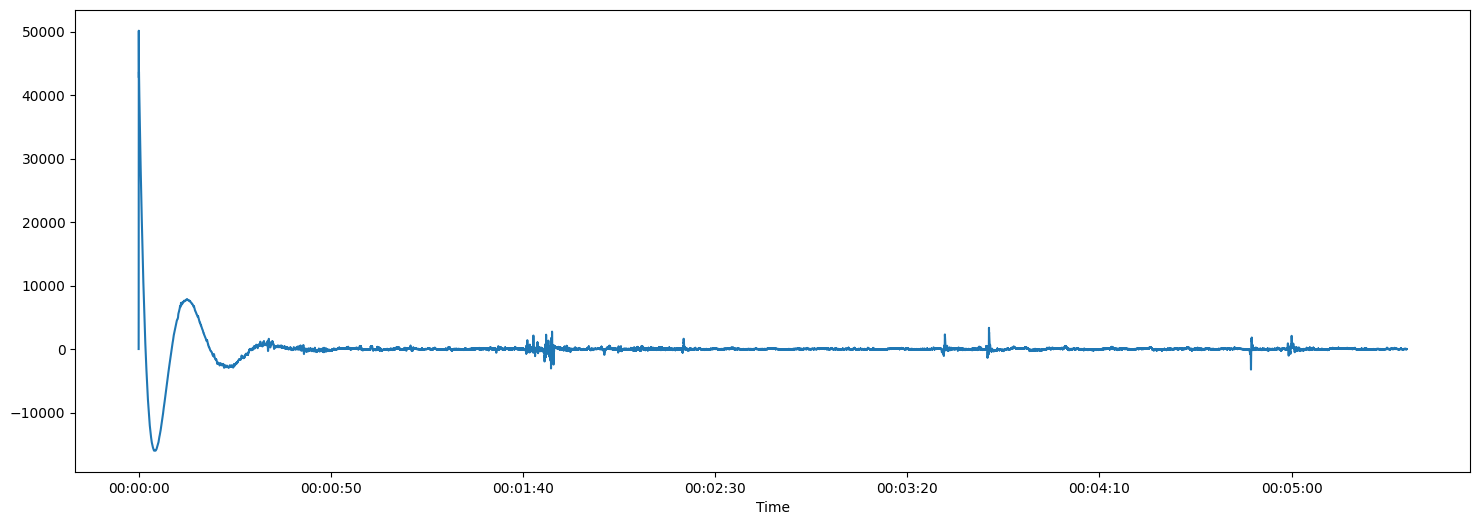

In [47]:
data['Fp1'][0:330000].plot(figsize=(18,6)) #просмотр данных, видны сигналы ЭОГ и много шумов

In [48]:
data

Fp1  Fp2
Time                  
00:00:00        0    0
00:00:00.001    5    7
00:00:00.002   22   34
00:00:00.003   68  104
00:00:00.004  160  244
...           ...  ...
00:21:07.064  -41  -52
00:21:07.065  -42  -65
00:21:07.066  -48  -82
00:21:07.067  -56 -101
00:21:07.068  -67 -121

[1267069 rows x 2 columns]

Сегментация данных

In [49]:
data_segment_fp1 = []
data_segment_fp2 = []

In [50]:
count = 14 #количество экспериментов
start_ind = int(1000*60*2.45) #время начало эксперимента
for i in range(count):
    start_ind += 1000*5
    data_segment_fp1.append(data['Fp1'][start_ind:start_ind+1000*60].to_numpy())
    data_segment_fp2.append(data['Fp2'][start_ind:start_ind+1000*60].to_numpy())
    start_ind += 1000*75

In [51]:
len(data_segment_fp2[0])

60000

Удаление аномалий

In [52]:
for i in range(len(data_segment_fp1)):
    data_segment_fp1[i] = check_anomaly(data_segment_fp1[i])

for i in range(len(data_segment_fp2)):
    data_segment_fp2[i] = check_anomaly(data_segment_fp2[i])

Удаление ЭОГ

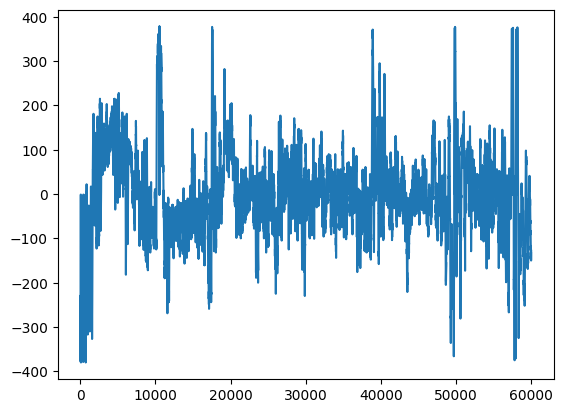

In [53]:
plt.plot(data_segment_fp1[4])
plt.show()

In [54]:
data_segment_fp1 = delete_eog(data_segment_fp1,100)
data_segment_fp2 = delete_eog(data_segment_fp2,100)

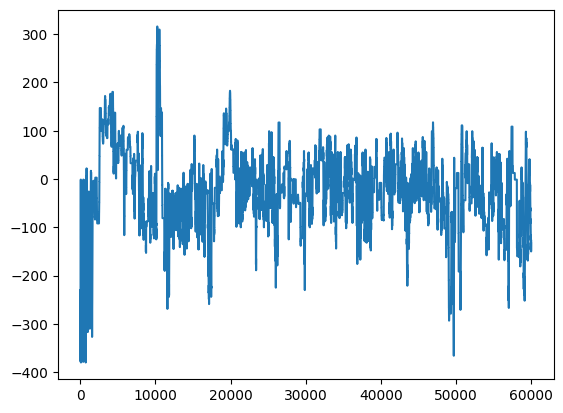

In [55]:
plt.plot(data_segment_fp1[4])
plt.show()

Понижение частоты 

In [56]:
data_segment_fp1_128 = filt_freq(data_segment_fp1)    
data_segment_fp2_128 = filt_freq(data_segment_fp2)

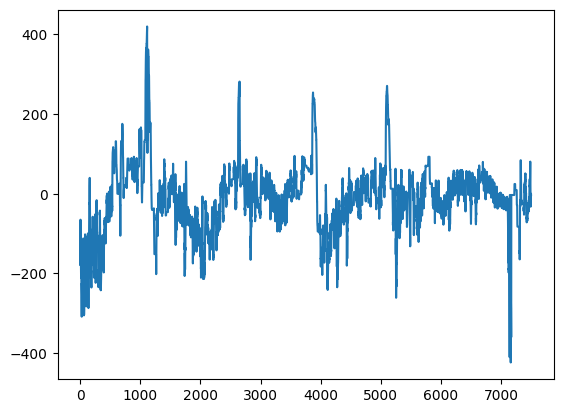

In [57]:
plt.plot(data_segment_fp1_128[1])
plt.show()

Применение полосового фильтра

In [58]:
for i in range(len(data_segment_fp1_128)):
    y = rfft(data_segment_fp1_128[i]) # мощность волн определённой частоты на графике
    x = rfftfreq(len(data_segment_fp1_128[i]), 1 / 128)
    
    for ind in range(len(x)):
        if (x[ind] < 4) or (x[ind] > 45):
            y[ind] = 0
    
    data_segment_fp1_128[i] = irfft(y)

for i in range(len(data_segment_fp2_128)):
    y = rfft(data_segment_fp2_128[i]) # мощность волн определённой частоты на графике
    x = rfftfreq(len(data_segment_fp2_128[i]), 1 / 128)
    
    for ind in range(len(x)):
        if (x[ind] < 4) or (x[ind] > 45):
            y[ind] = 0
    
    data_segment_fp2_128[i] = irfft(y)

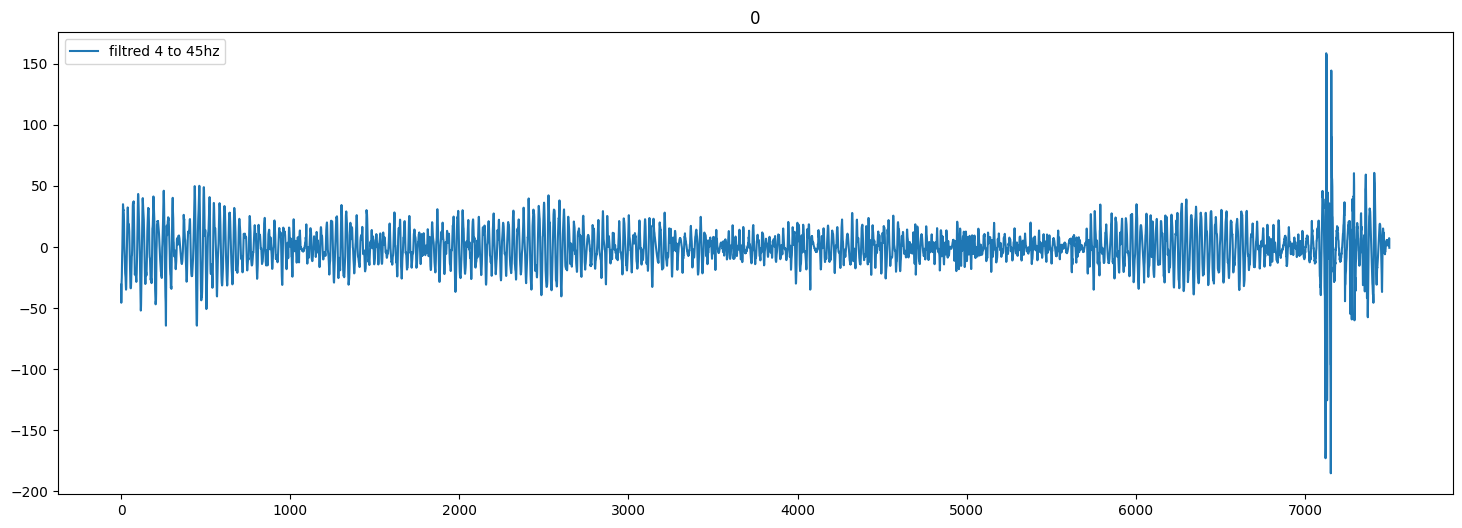

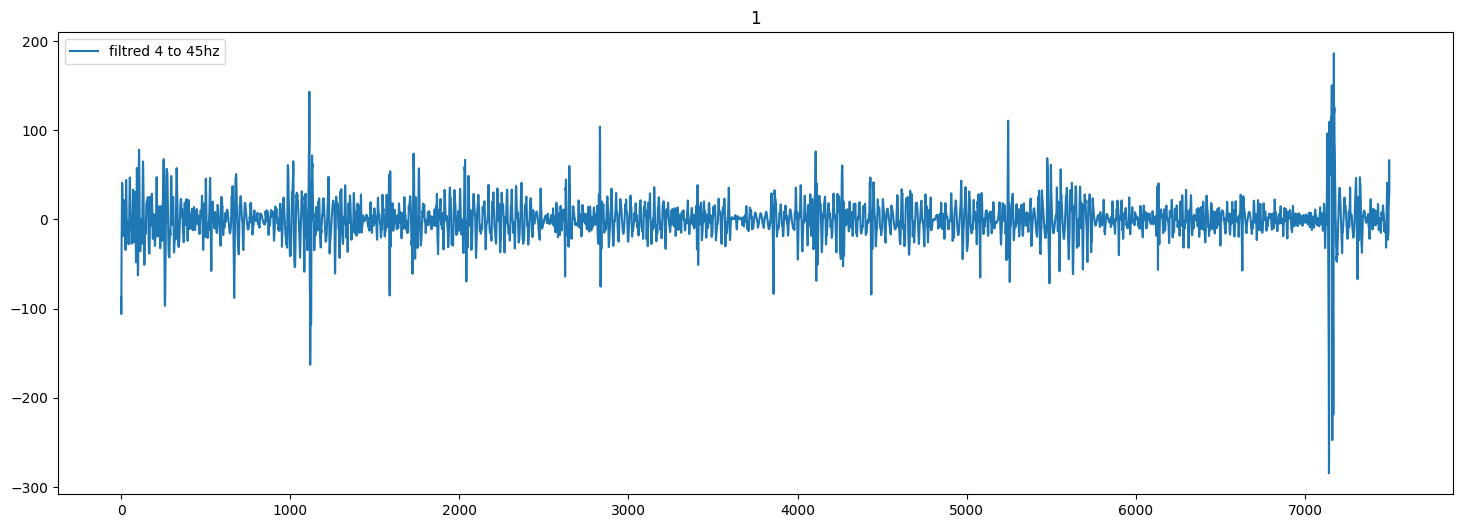

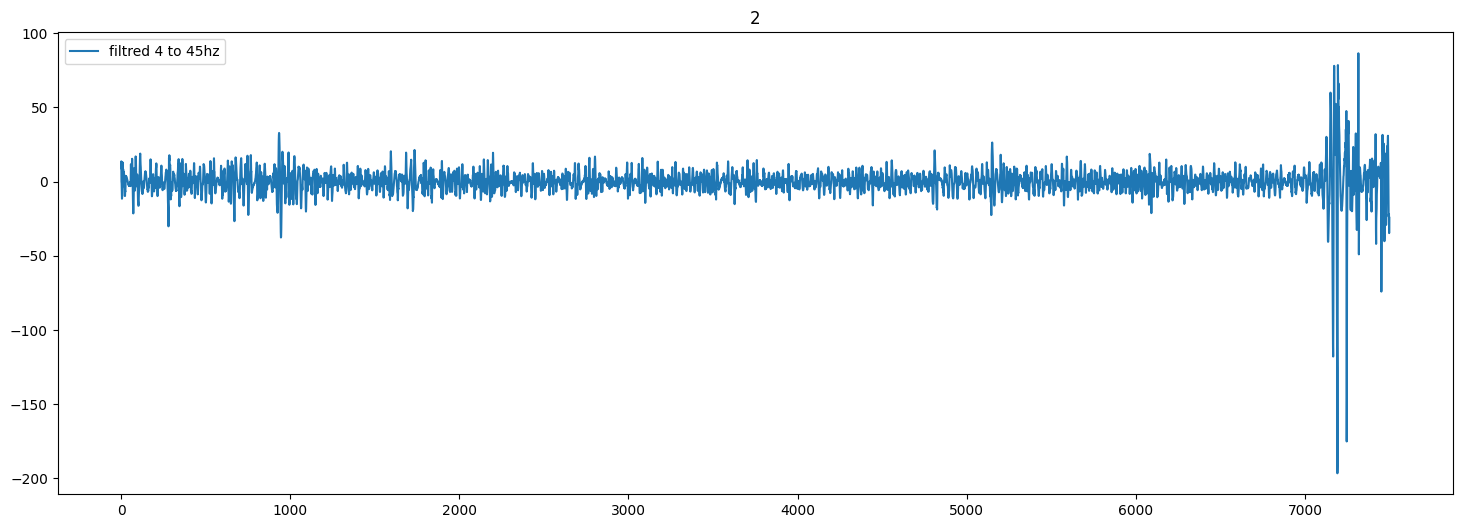

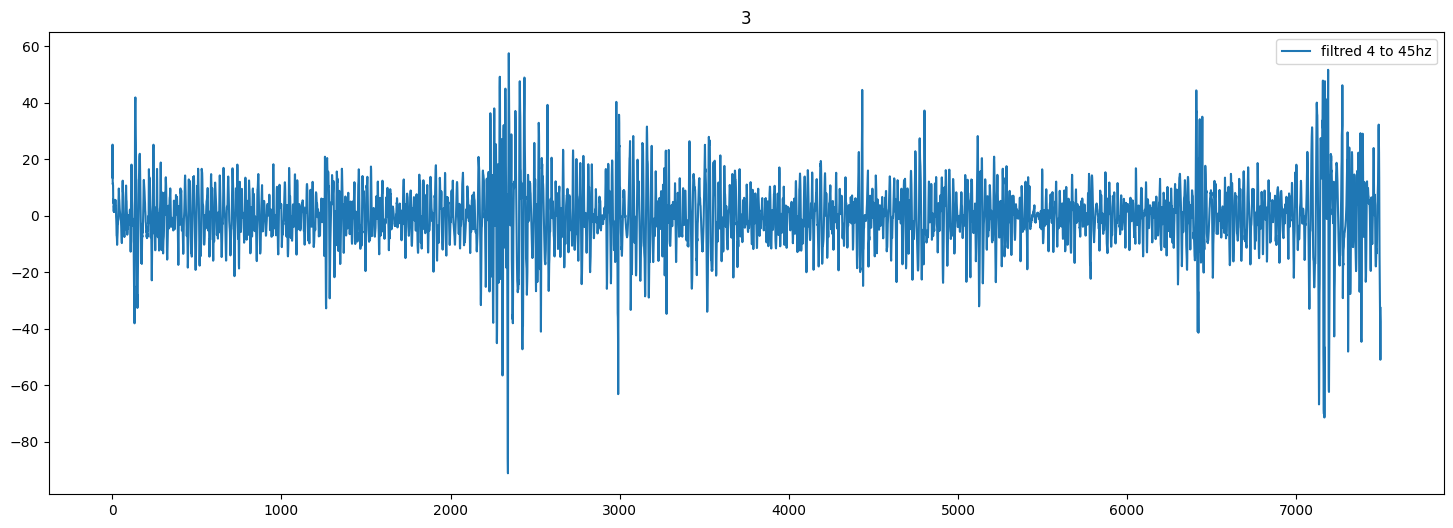

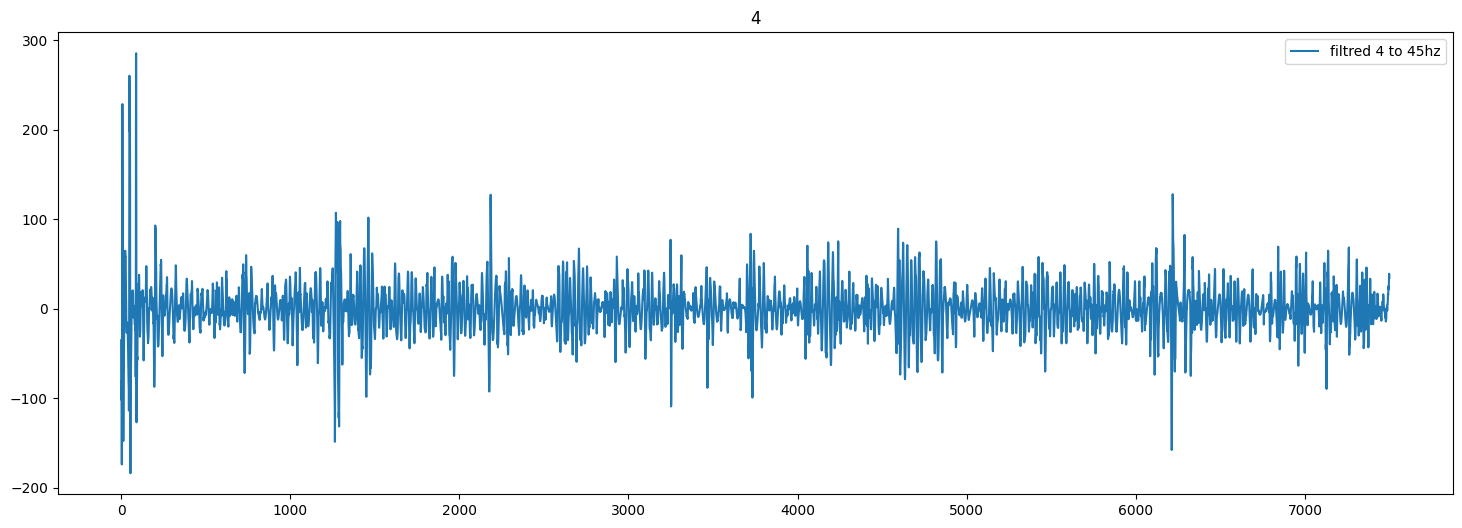

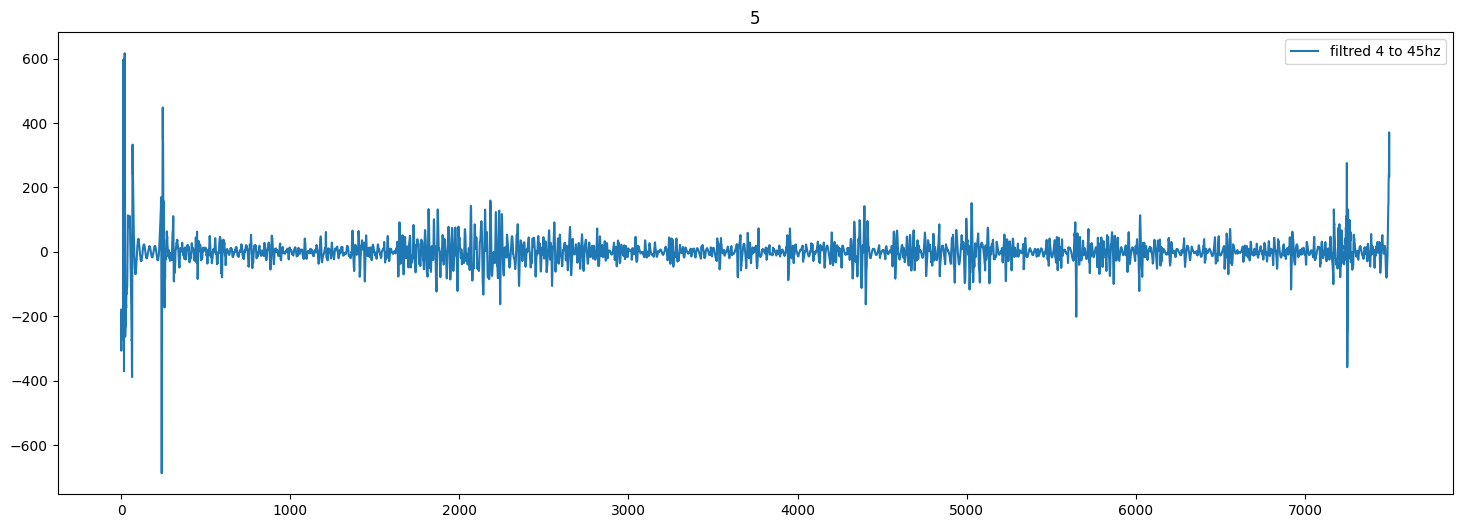

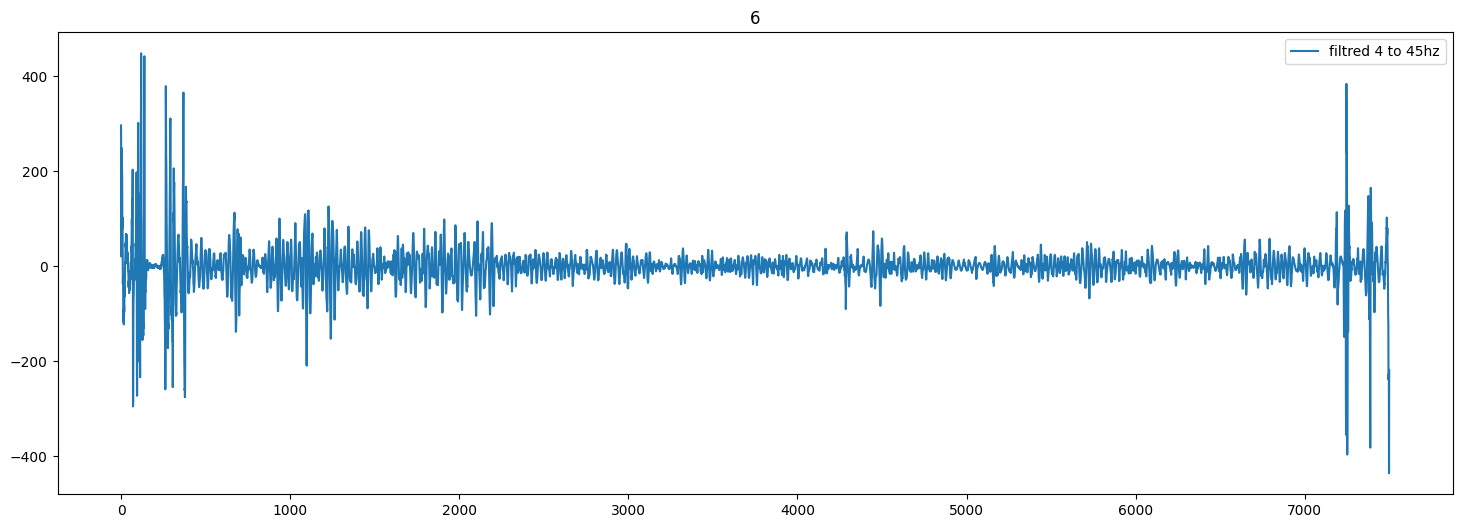

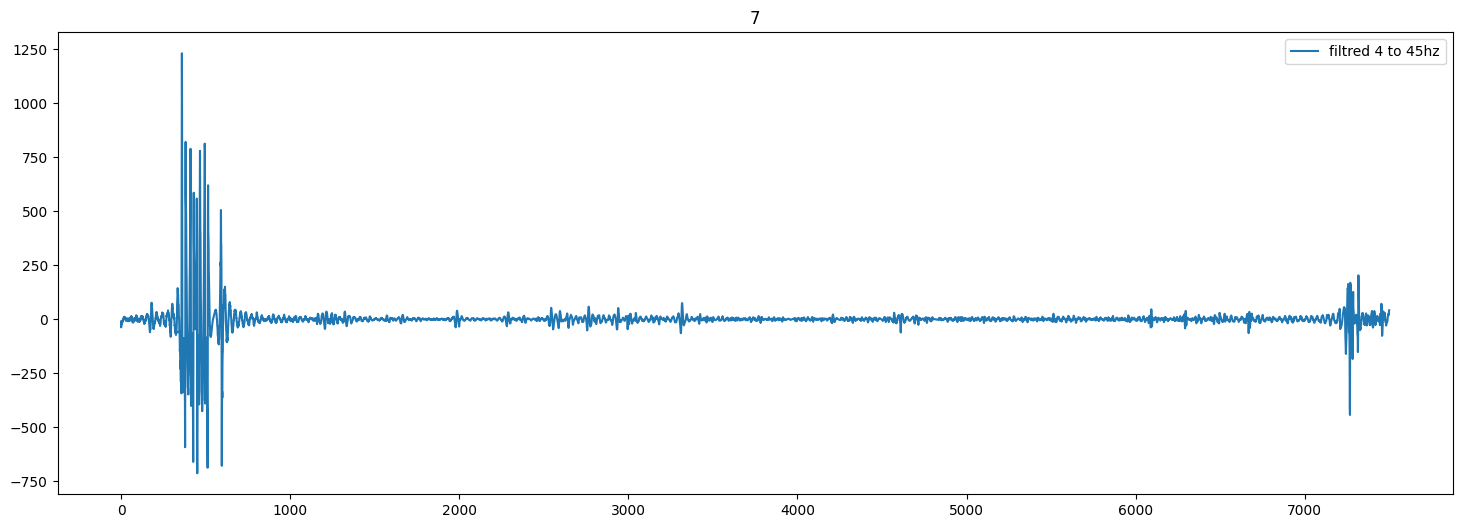

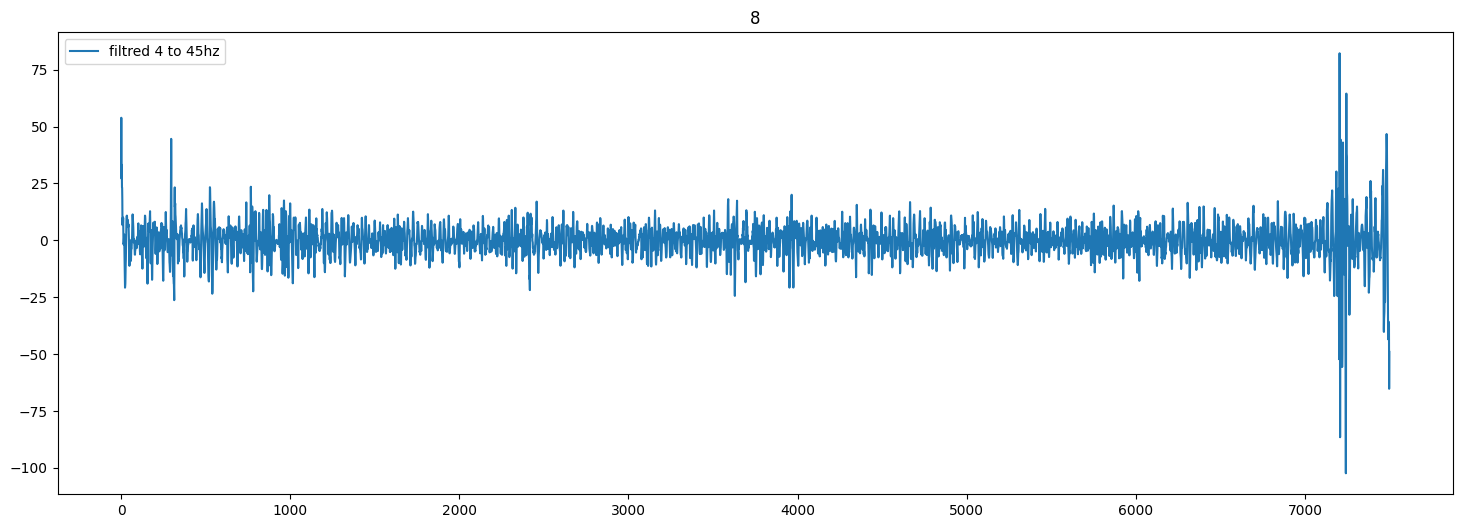

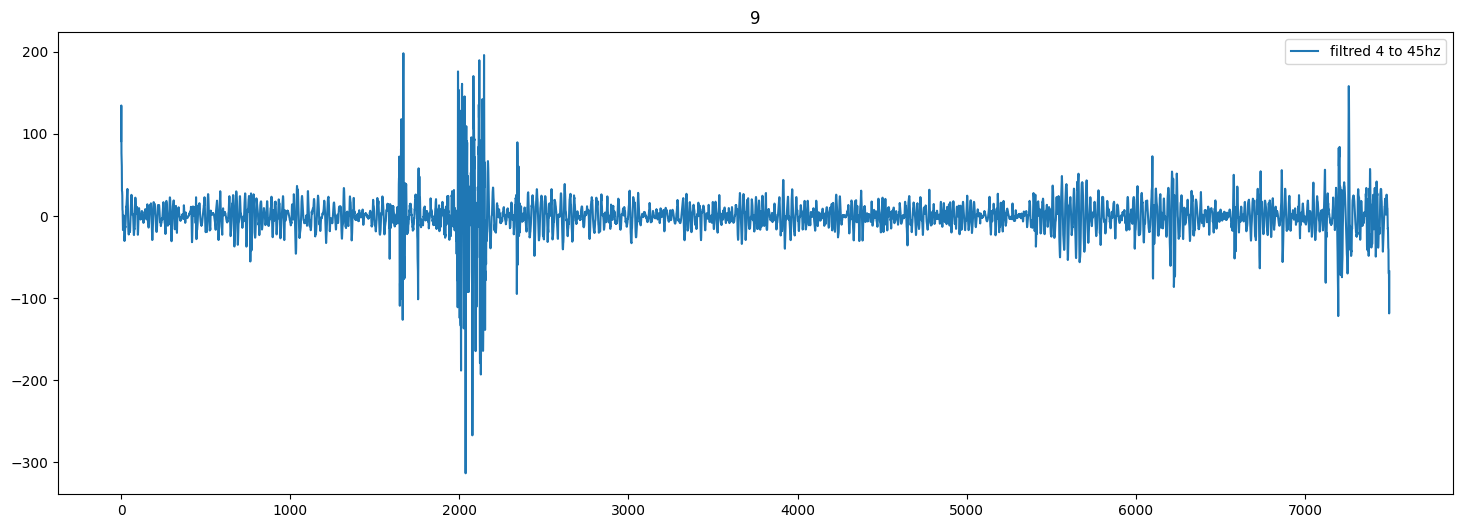

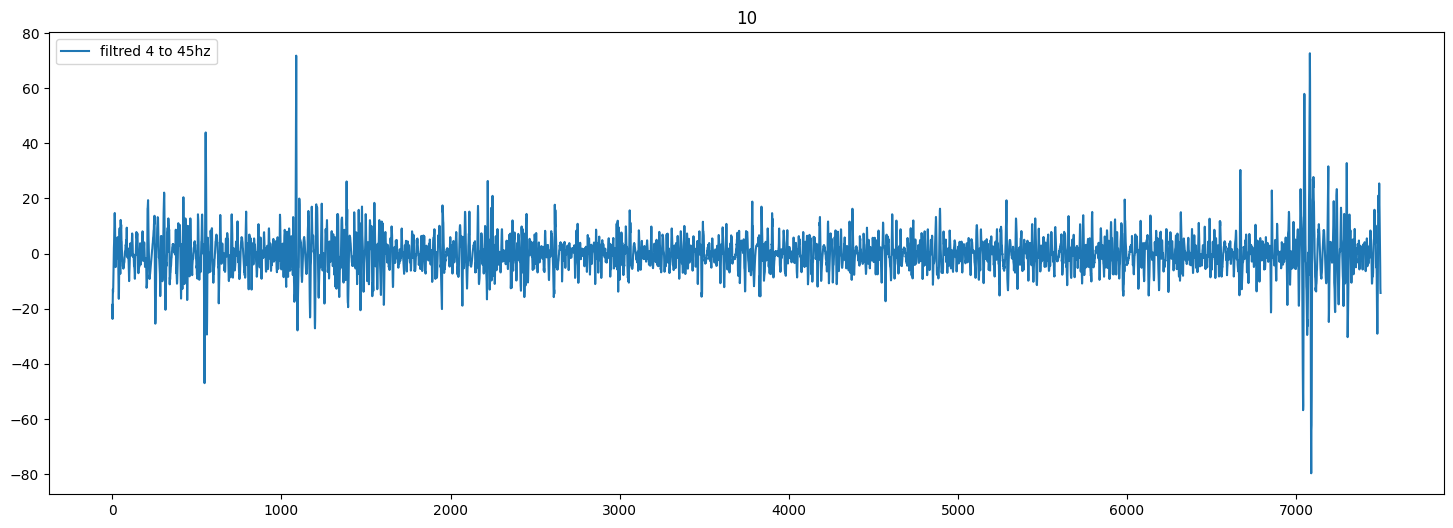

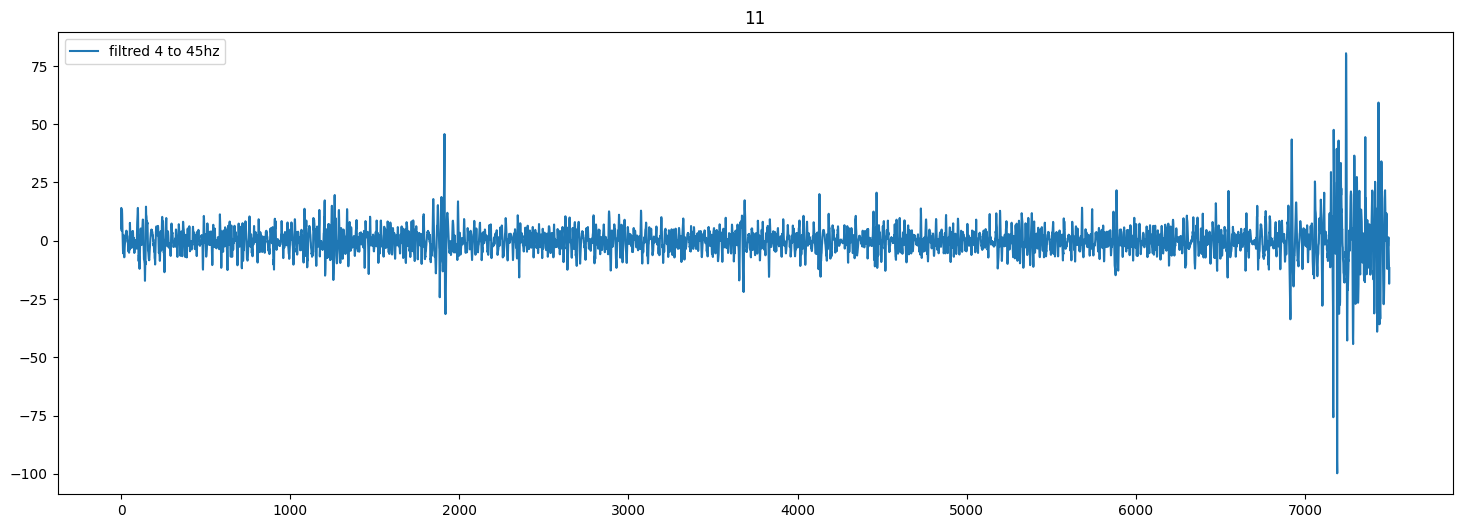

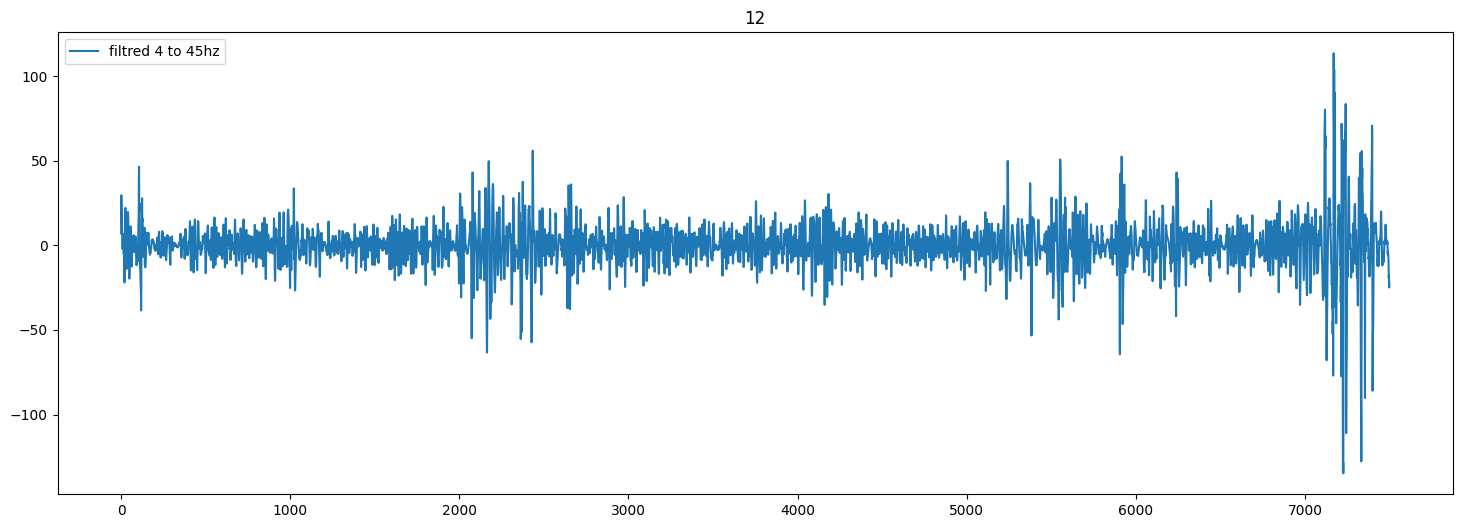

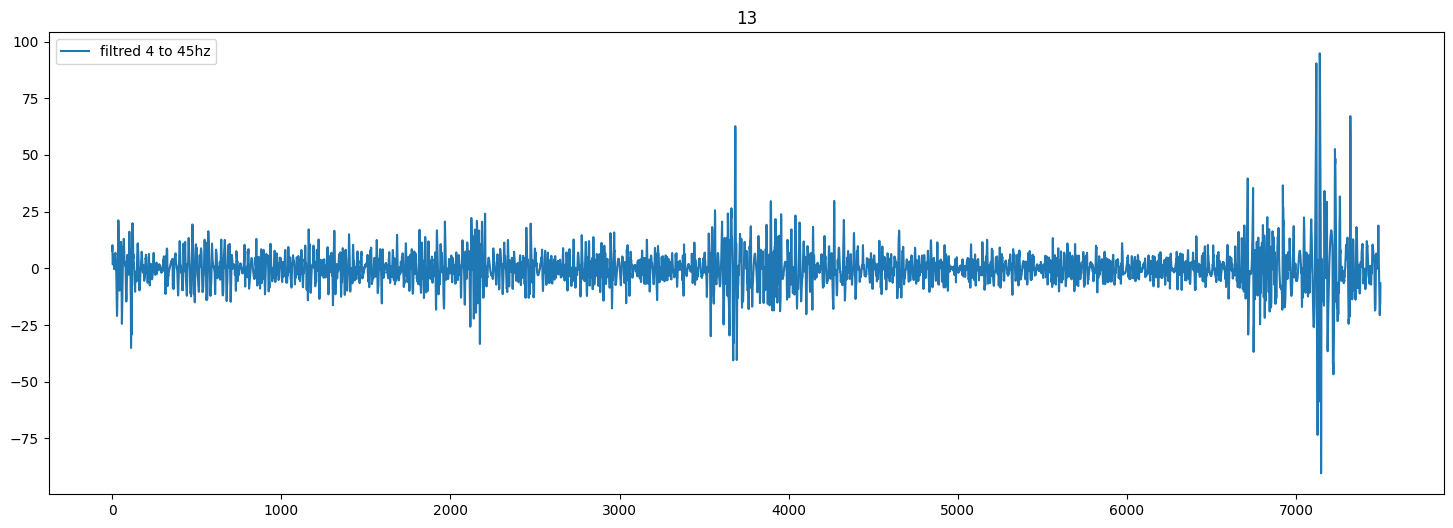

In [59]:
for i in range(14):
    plt.figure(figsize=(18, 6)) 
    plt.plot(data_segment_fp1_128[i],label='filtred 4 to 45hz')
    plt.title(str(i))
    plt.legend(loc='best')
    plt.show()

In [60]:
#дополнительное удаление аномальных значений, много шумов
for i in range(len(data_segment_fp1_128)):
    data_segment_fp1_128[i] = check_anomaly(data_segment_fp1_128[i])

for i in range(len(data_segment_fp2)):
    data_segment_fp2_128[i] = check_anomaly(data_segment_fp2_128[i])

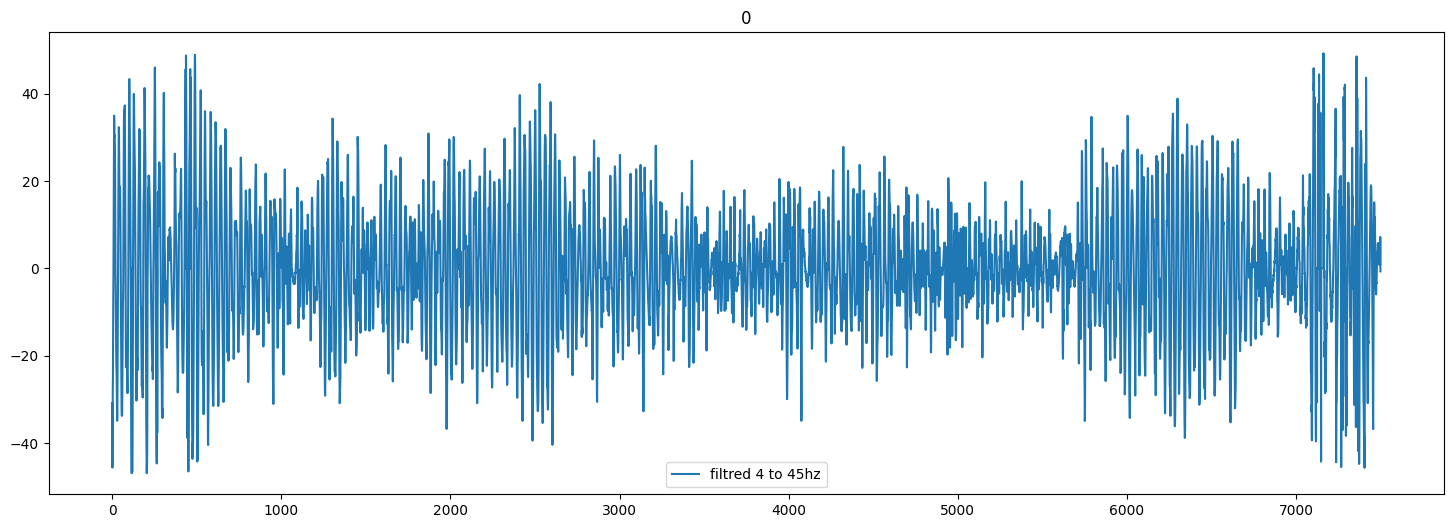

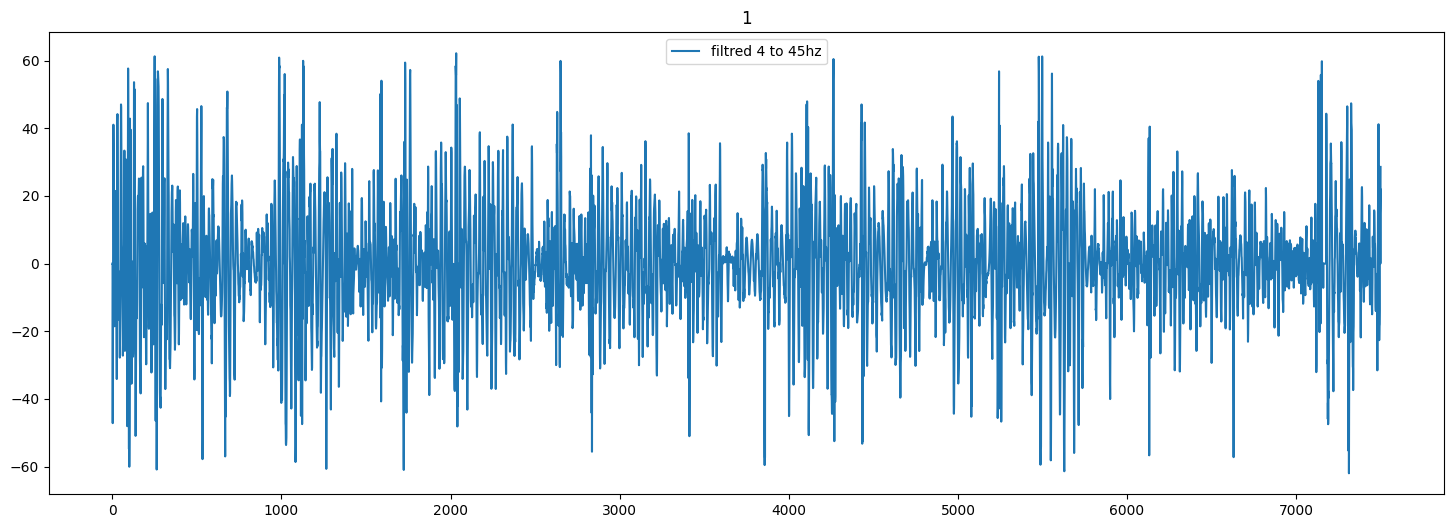

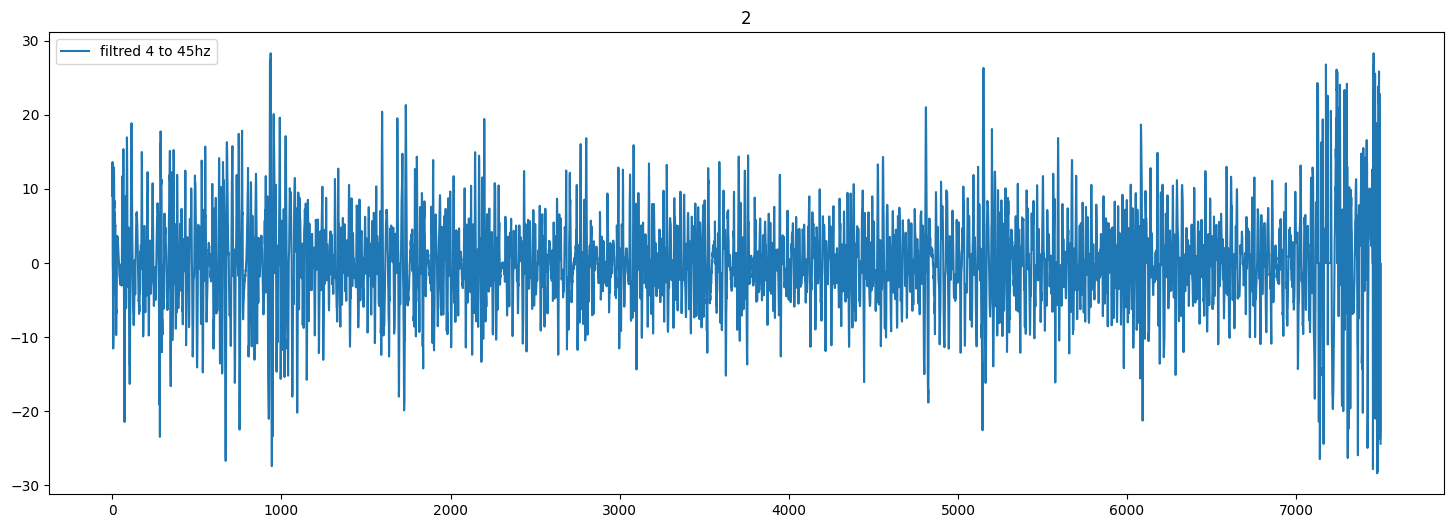

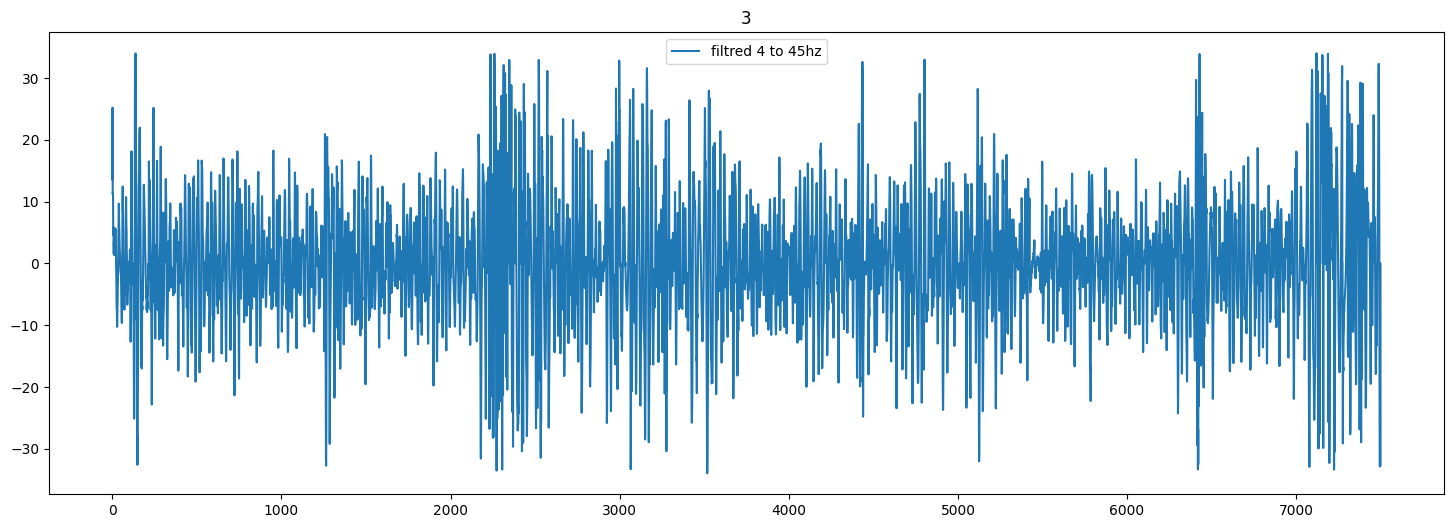

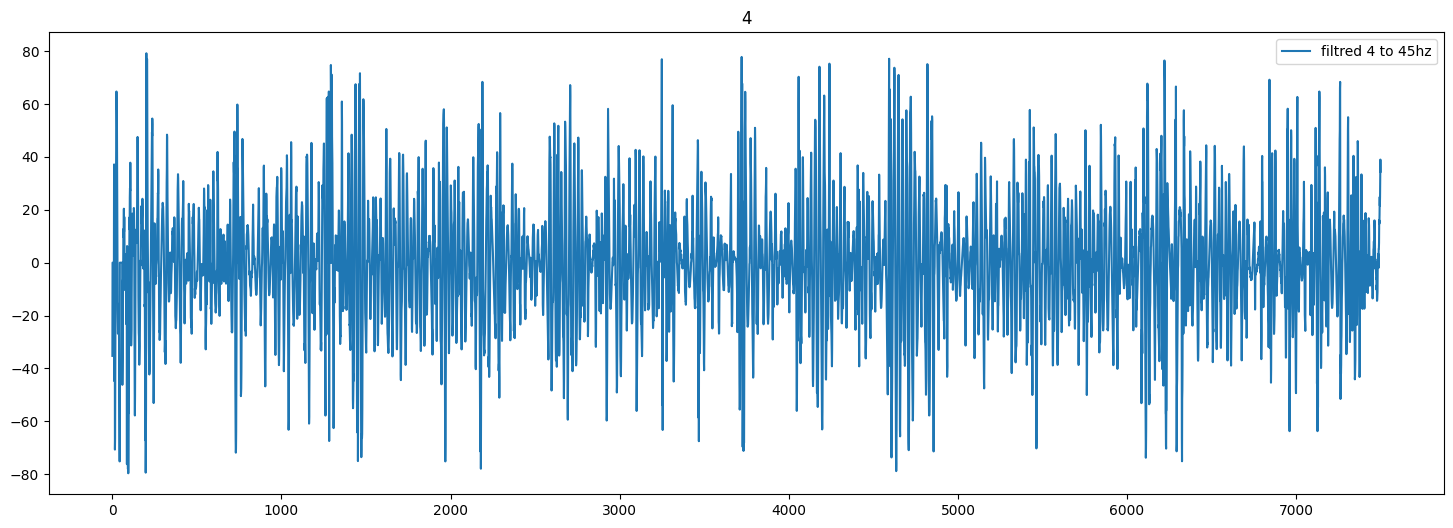

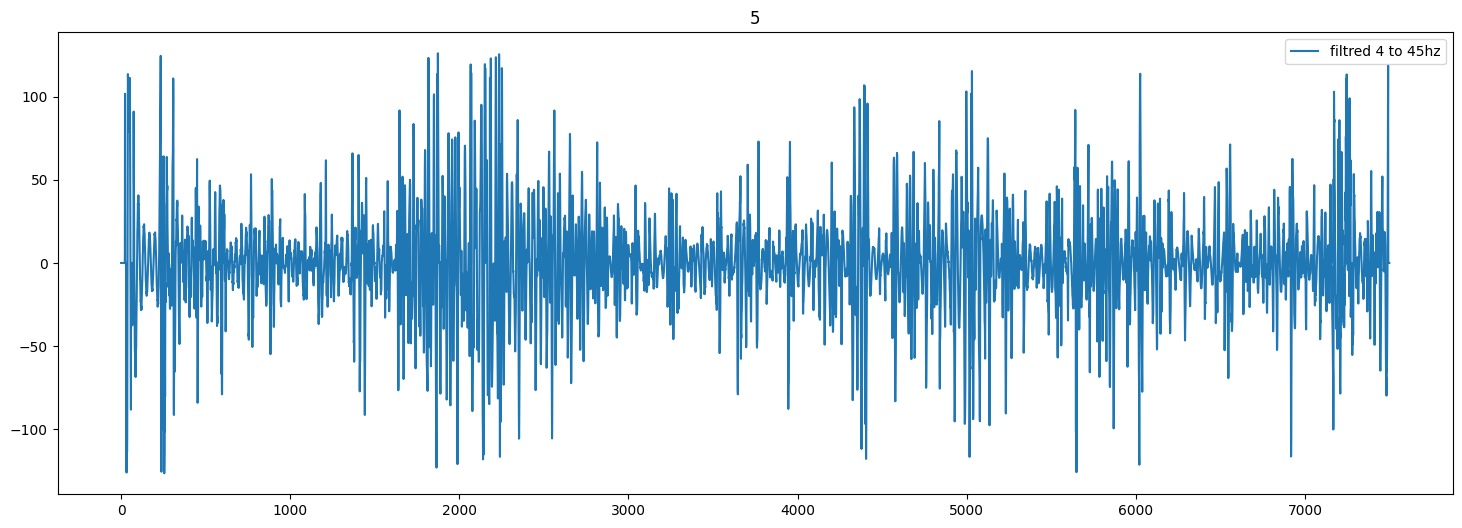

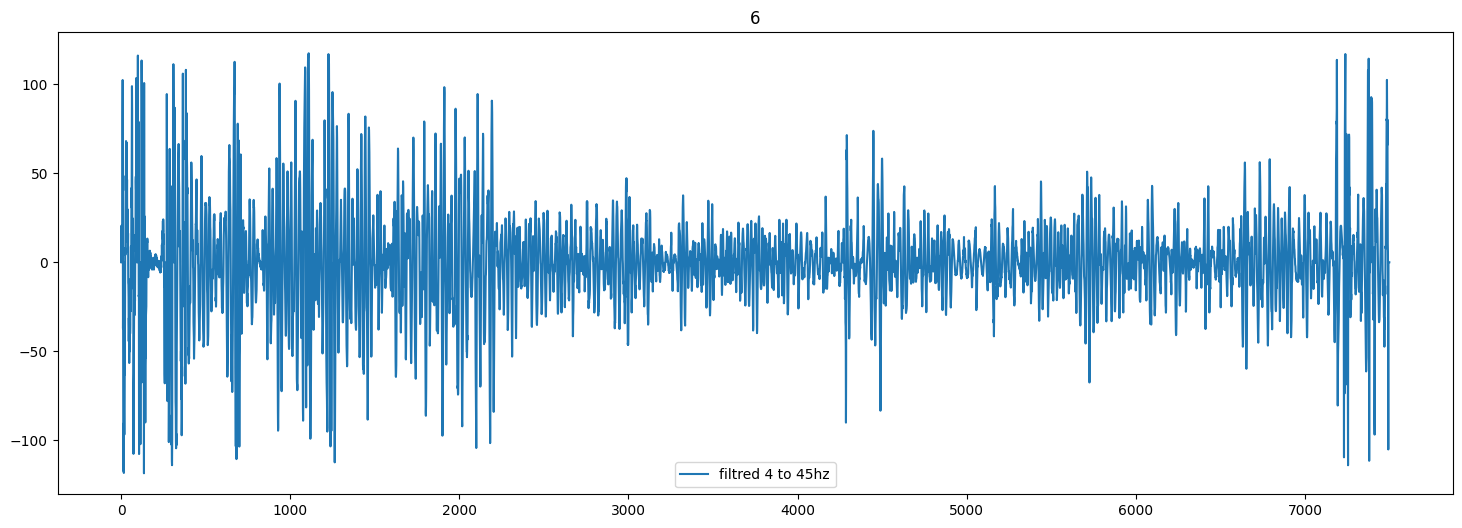

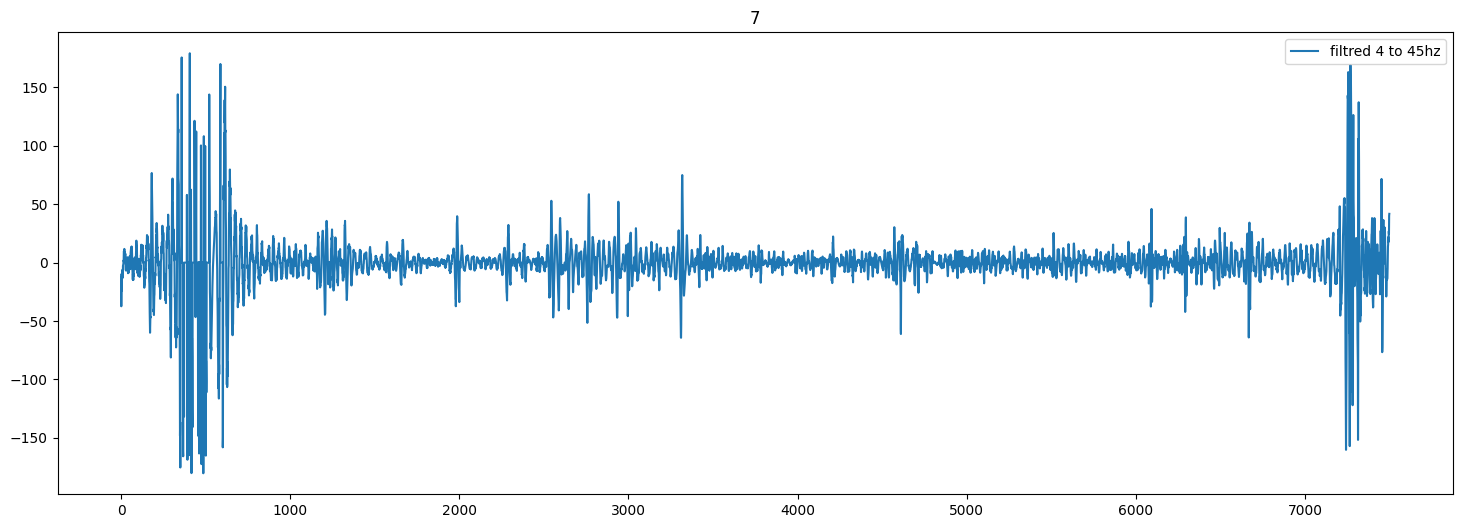

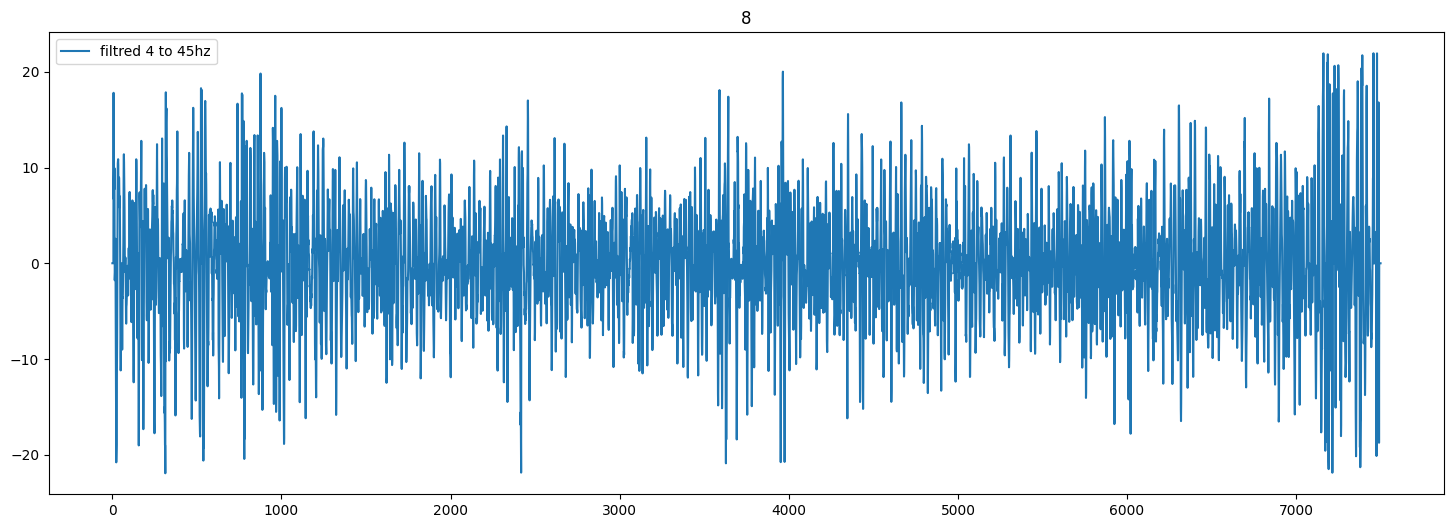

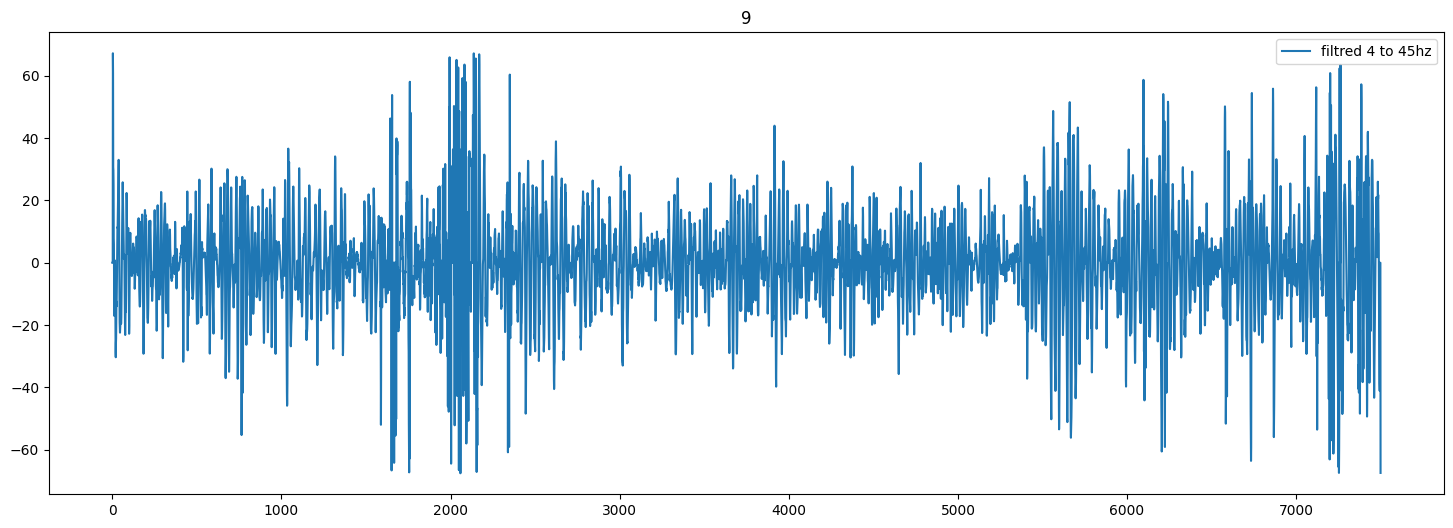

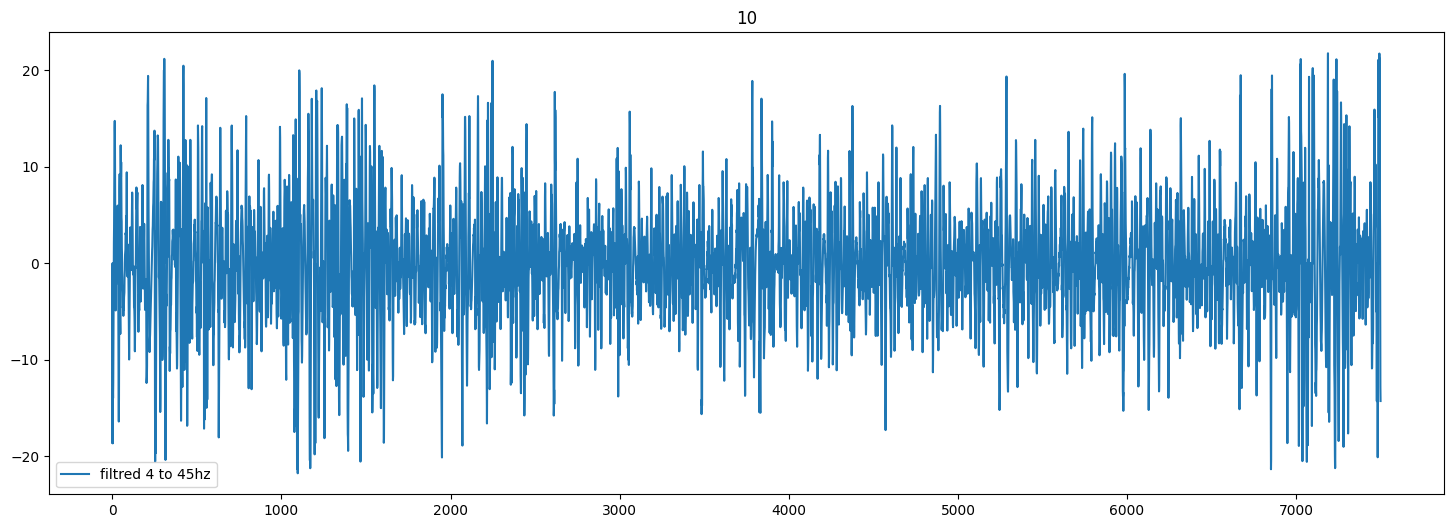

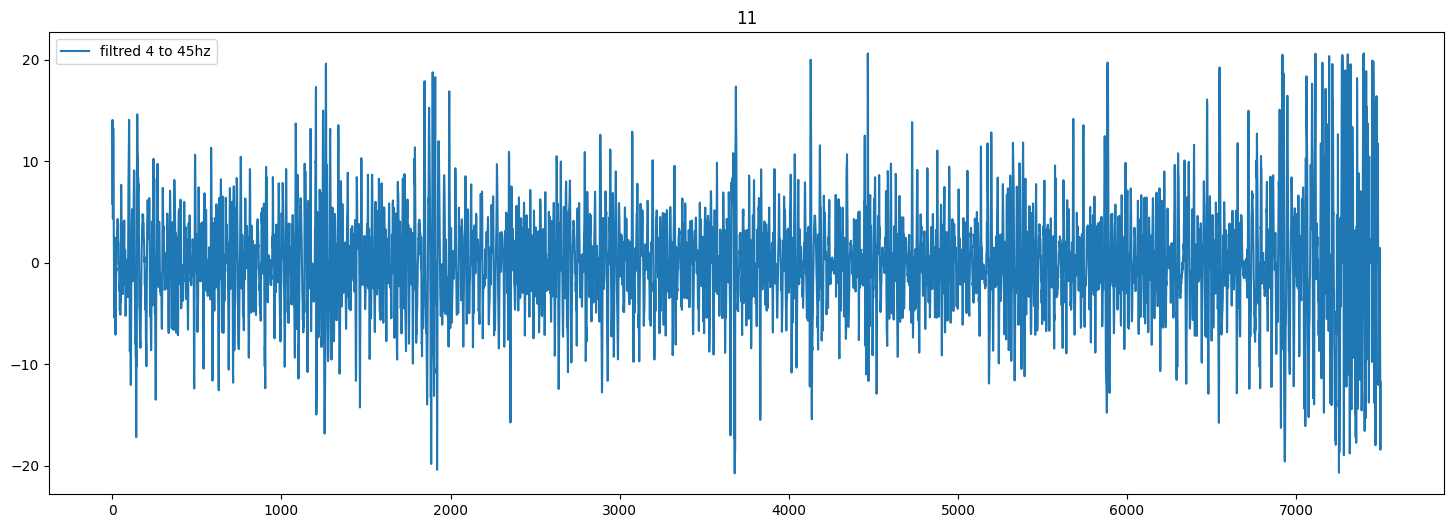

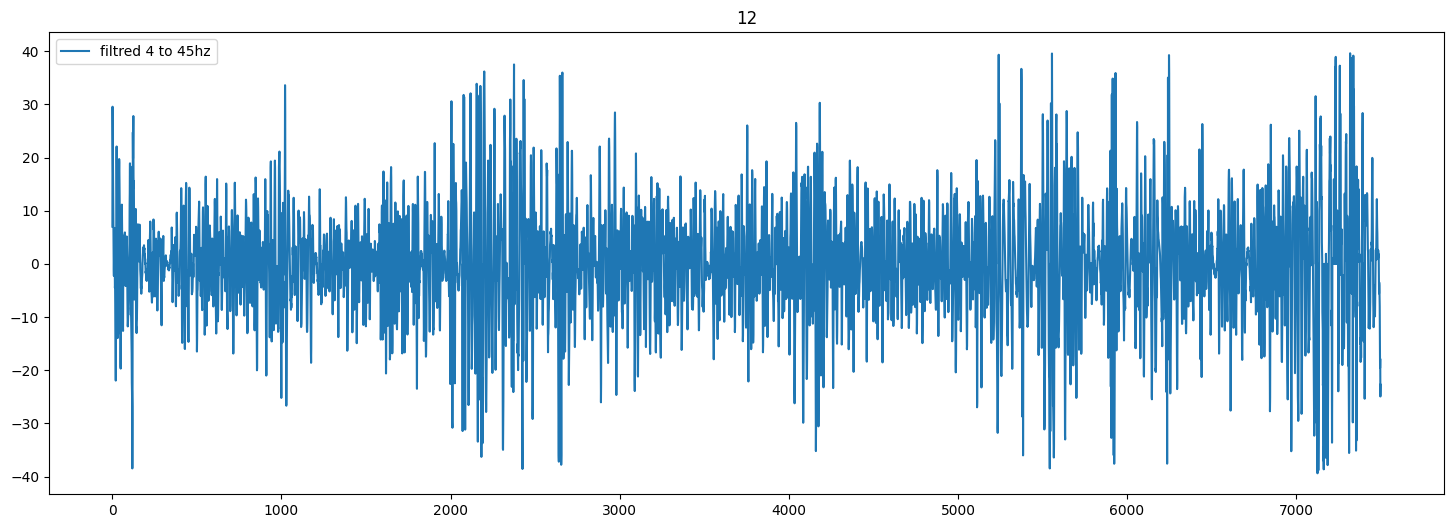

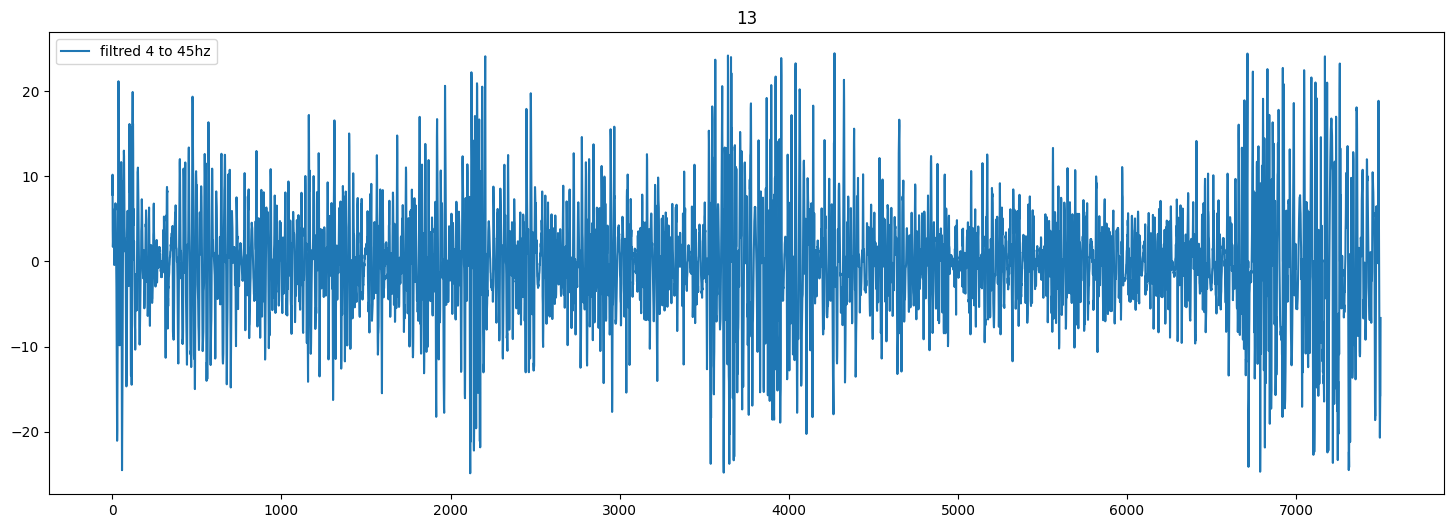

In [61]:
for i in range(14):
    plt.figure(figsize=(18, 6)) 
    plt.plot(data_segment_fp1_128[i],label='filtred 4 to 45hz')
    plt.title(str(i))
    plt.legend(loc='best')
    plt.show()

In [62]:
indexes_to_save = [0,1,2,4,8,10,11,13]

In [63]:
data_fp1_to_save = []
for elem in indexes_to_save:
    data_fp1_to_save.append(data_segment_fp1_128[elem])

In [64]:
data_fp2_to_save = []
for elem in indexes_to_save:
    data_fp2_to_save.append(data_segment_fp2_128[elem])

In [65]:
pd.DataFrame(data_fp1_to_save).to_csv('bioradio_2_fp1.csv')
pd.DataFrame(data_fp2_to_save).to_csv('bioradio_2_fp2.csv')

In [66]:
raitings = pd.DataFrame(columns=['valence','arousal','dominance','liking'])
raitings['valence'] = [7,9,5,7,9,9,7,6,6,6,3,6,5,2]
raitings['arousal'] = [5,9,3,4,9,9,6,7,8,3,1,5,2,1]
raitings['dominance'] = [7,9,3,5,9,9,8,6,7,4,2,4,3,2]
raitings['liking'] = [4,5,3,3,5,5,4,4,4,3,2,3,2,2]
raitings

valence  arousal  dominance  liking
0         7        5          7       4
1         9        9          9       5
2         5        3          3       3
3         7        4          5       3
4         9        9          9       5
5         9        9          9       5
6         7        6          8       4
7         6        7          6       4
8         6        8          7       4
9         6        3          4       3
10        3        1          2       2
11        6        5          4       3
12        5        2          3       2
13        2        1          2       2

In [67]:
valence = []
for elem in raitings['valence']:
    if elem >= 5:
           valence.append(1)
    else:
           valence.append(0)
raitings['valence_model'] = valence

arousal = []
for elem in raitings['arousal']:
    if elem >= 5:
           arousal.append(1)
    else:
           arousal.append(0)
raitings['arousal_model'] = arousal

In [68]:
raitings

valence  arousal  dominance  liking  valence_model  arousal_model
0         7        5          7       4              1              1
1         9        9          9       5              1              1
2         5        3          3       3              1              0
3         7        4          5       3              1              0
4         9        9          9       5              1              1
5         9        9          9       5              1              1
6         7        6          8       4              1              1
7         6        7          6       4              1              1
8         6        8          7       4              1              1
9         6        3          4       3              1              0
10        3        1          2       2              0              0
11        6        5          4       3              1              1
12        5        2          3       2              1              0
13        2        1          2       2              0              0

In [69]:
raitings = raitings.drop(index=[3,5,6,7,9,12])
raitings

valence  arousal  dominance  liking  valence_model  arousal_model
0         7        5          7       4              1              1
1         9        9          9       5              1              1
2         5        3          3       3              1              0
4         9        9          9       5              1              1
8         6        8          7       4              1              1
10        3        1          2       2              0              0
11        6        5          4       3              1              1
13        2        1          2       2              0              0

In [70]:
raitings.to_csv('bioradio_raiting_2.csv')

In [71]:
fp1 = pd.concat([pd.read_csv('bioradio_1_fp1.csv',index_col=0),pd.read_csv('bioradio_2_fp1.csv',index_col=0)], ignore_index=True)
fp1

0             1             2             3             4  \
0  -3.849919e+01 -5.929816e+01 -3.307661e+01 -3.071246e+01 -2.995567e+01   
1  -4.251346e+01 -7.316744e+01 -5.028833e+01 -4.550424e+01 -3.765035e+01   
2  -6.849123e+00 -6.146757e+00 -1.028076e+01 -1.059676e+01 -1.195717e+01   
3  -7.898672e+00 -9.155248e+00  1.009405e+00  1.791130e+00 -1.928346e+00   
4  -2.067540e+01 -2.521411e+01 -7.969747e+00 -5.701225e+00 -3.856441e+00   
5   2.458207e+01  3.923494e+01  2.254733e+01  2.085261e+01  2.027737e+01   
6   5.772096e+01  5.773491e+01  4.449593e+01  3.048904e+01  2.238845e+01   
7  -2.416389e+01 -4.478401e+01 -3.756807e+01 -3.674114e+01 -4.390259e+01   
8   2.000587e+01  2.230850e+01  2.449438e+01  2.977351e+01  3.274084e+01   
9   8.888262e+01  1.535209e+02  8.629260e+01  7.872559e+01  7.811452e+01   
10  4.910868e+01  6.598185e+01  2.884352e+01  2.415164e+01  2.626045e+01   
11 -3.085361e+01 -4.562900e+01 -3.483685e+01 -2.812082e+01 -2.505679e+01   
12 -2.273737e-17 -2.273737e-17 -4.716537e+01 -2.140284e+01  5.219074e+00   
13  9.079258e+00  1.362132e+01  7.500346e-02 -1.133679e+00 -5.139739e+00   
14 -3.526260e+01  1.250555e-16  1.250555e-16  1.250555e-16  1.250555e-16   
15  1.894781e-17  1.894781e-17  1.894781e-17  1.894781e-17  1.894781e-17   
16 -1.857926e+01 -2.084259e-17 -1.865446e+01 -1.296351e+01 -1.397316e+01   
17  5.813979e+00  1.408171e+01  9.866235e+00  4.359148e+00  7.067531e+00   
18  7.830038e+00  1.017420e+01  3.739207e+00  1.706369e+00  2.308710e+00   

               5             6             7             8             9  ...  \
0  -1.773714e+01 -1.823522e+01 -1.592610e+01 -6.132045e+00 -1.158460e+00  ...   
1  -1.594424e+01 -9.312208e+00 -2.441630e+00  8.029726e+00  6.661255e+00  ...   
2  -1.214894e+01 -1.067431e+01 -1.041118e+01 -7.193057e+00 -3.738355e+00  ...   
3  -3.564368e+00 -6.236408e+00 -6.120188e+00 -2.751774e+00 -1.005802e+00  ...   
4   4.844875e+00  6.549763e+00  8.002650e+00  9.380259e+00  4.006309e+00  ...   
5   1.174984e+01  1.101821e+01  9.489922e+00  4.302590e+00  4.566412e+00  ...   
6   1.627970e+01  1.266064e+01  1.016470e+01  3.149916e+00 -4.736913e+00  ...   
7  -3.877905e+01 -3.406654e+01 -3.114985e+01 -1.943600e+01 -1.102321e+01  ...   
8   3.235609e+01  3.147026e+01  2.977366e+01  2.577083e+01  1.900291e+01  ...   
9   4.236904e+01  3.866739e+01  3.211885e+01  9.705492e+00  1.031100e+01  ...   
10  1.239401e+01  9.455424e+00  2.151188e+00 -1.061022e+01 -8.834317e+00  ...   
11 -1.408972e+01 -6.758604e+00 -1.746485e+00  9.151132e+00  1.910436e+01  ...   
12  3.980998e+01  4.104635e+01  3.523696e+01  2.931538e+01  1.092320e+01  ...   
13 -1.152771e+01 -1.036712e+01 -9.278217e+00 -6.252480e-01  1.291583e+01  ...   
14  1.250555e-16  1.250555e-16  1.250555e-16  1.250555e-16  1.250555e-16  ...   
15  1.894781e-17  1.894781e-17  1.780710e+01  6.700284e+00  8.934611e+00  ...   
16 -1.239645e+01 -8.557405e+00 -6.093435e+00 -1.535368e+00  2.097816e+00  ...   
17  1.329398e+01  1.150710e+01  6.109827e+00  4.070424e+00  1.195793e+00  ...   
18  2.372509e+00  4.449508e+00  5.991438e+00  5.033496e+00  4.173907e+00  ...   

         7490          7491          7492          7493          7494  \
0   -0.011188 -2.707195e+00  4.596512e+00  7.060182e+00  8.112768e+00   
1    1.882364  6.425552e+00  1.936263e+01  2.599801e+01  2.815130e+01   
2   13.599759  9.832402e+00  4.432622e+00  5.097623e-01 -2.220394e+00   
3   -4.981062 -3.627873e+00  1.552358e+00  4.170099e+00  6.139570e+00   
4   -3.591314 -5.508129e+00  2.877794e-01  5.462526e+00  6.551282e+00   
5   -3.282235 -4.850836e+00 -1.010944e+01 -9.670110e+00 -9.457491e+00   
6  -69.935815 -5.906401e+01 -4.226219e+01 -2.254395e+01 -8.065412e+00   
7   34.883519  3.740786e+01  3.963011e+01  2.675805e+01  2.994678e+01   
8  -37.646095 -4.497295e+01 -4.663724e+01 -4.540275e+01 -4.273936e+01   
9    0.861283 -8.189786e-01 -2.460248e+01 -3.578908e+01 -4.088149e+01   
10  -5.000200 -3.868775e+00 -1.100105e+01 -1.257609e+01 -1.248677e+01 

In [72]:
fp1.to_csv('bioradio_fp1_all.csv')

In [73]:
fp2 = pd.concat([pd.read_csv('bioradio_1_fp2.csv',index_col=0),pd.read_csv('bioradio_2_fp2.csv',index_col=0)], ignore_index=True)
fp2

0             1             2             3             4  \
0  -2.123448e+01 -3.107606e+01 -1.466707e+01 -1.390470e+01 -1.616987e+01   
1   3.613796e+01  4.994303e+01  2.733710e+01  2.649083e+01  2.831571e+01   
2  -1.459158e+02 -1.546138e+02 -1.493213e+01  1.642913e+01 -1.215733e+01   
3  -3.240887e+00 -1.079514e+00  4.298028e+00  1.089490e+01  1.207178e+01   
4  -1.648752e+01 -1.529233e+01 -8.654719e-01 -2.825994e-01 -4.133314e+00   
5   2.740011e+01  4.394283e+01  2.604093e+01  2.450572e+01  2.384334e+01   
6   2.374898e+01  7.961275e+01  4.240008e+01  3.945233e+01  4.831148e+01   
7   1.011589e+02  1.442800e+02  8.533958e+01  7.209031e+01  6.099182e+01   
8   9.751445e+01  1.535048e+02  9.694059e+01  9.290671e+01  9.146639e+01   
9   3.020987e+01  5.585323e+01  3.143685e+01  2.896358e+01  2.947277e+01   
10  3.657916e+01  4.925114e+01  2.166459e+01  1.894484e+01  1.915260e+01   
11 -1.606426e+01 -2.723877e+01 -2.131150e+01 -1.295781e+01 -9.442633e+00   
12  1.515825e-17  1.515825e-17 -4.902155e+01 -2.015932e+01  1.478346e+01   
13  1.328620e+00 -9.080465e+00 -1.134083e+01 -1.098665e+01 -1.741101e+01   
14  3.767240e+01  1.239807e+01  1.230071e+01 -7.823608e-01 -1.395146e+01   
15 -1.894781e-17 -1.894781e-17 -1.894781e-17 -1.894781e-17 -1.894781e-17   
16  1.313906e+00  1.783594e+00 -5.200455e+00  1.418704e+00 -2.744884e+00   
17 -7.373086e+00  7.696873e+00  1.468536e+01  1.638425e+01  1.691840e+01   
18  2.222282e+00  4.736899e+00 -9.590851e-01 -8.416382e-01  1.080890e+00   

            5          6          7          8          9  ...          7490  \
0  -11.308004 -12.607403 -12.912526  -8.195089  -4.019641  ... -4.117368e+00   
1   19.075603  17.977090  16.418215  11.335694   9.658307  ... -3.419582e+00   
2    9.461961  10.460240   0.781675  15.082801  11.022576  ...  3.042904e+01   
3    8.144954   2.075215  -4.345575  -7.510584  -5.571870  ...  4.192486e+00   
4   -4.457301  -5.226356   0.633972   9.578792  11.369784  ...  1.499390e+00   
5   14.413935  13.853495  11.348011   5.636200   5.928005  ... -1.677686e+00   
6   25.422125  32.780046  42.826590  29.789218  32.104214  ...  9.184286e+01   
7   25.580237  16.539776   4.134540 -13.512382  -5.683020  ... -2.649886e+01   
8   60.995325  56.558798  44.769497  22.035452  19.716542  ... -2.408857e+01   
9   17.072346  15.823362  13.856238   5.948447   5.576235  ...  3.052848e+00   
10   5.148422   2.616438   0.485163  -7.795947  -8.239681  ... -2.259507e+00   
11  -2.355170   1.712543   4.284474  12.224667  18.619346  ...  2.285953e+00   
12  51.953204  52.606893  44.418709  33.580523  12.465909  ... -2.266071e-01   
13 -17.823627 -18.206960 -18.683553  -3.056395   9.205946  ... -8.052818e-18   
14 -20.436275 -36.632735 -51.335320 -60.137874 -69.205491  ... -6.886278e+00   
15  18.582972  18.648591  13.806507   1.946428   3.375772  ... -9.494670e+00   
16  -7.270739  -2.838546  -3.477924  -1.575751   2.701904  ...  2.368476e-17   
17  16.061244  14.326602  11.791565   8.093683   4.821281  ... -4.179852e+00   
18   1.369265   3.923759   4.918397   4.344517   6.235705  ...  4.860819e+00   

            7491          7492          7493        7494          7495  \
0  -2.652068e+00  2.925997e+00  6.611038e+00   10.468949  1.986005e+01   
1  -8.190891e+00 -1.755380e+01 -1.887591e+01  -18.447005 -2.748189e+01   
2   1.661697e+01  2.197336e+01  2.505795e+01   15.273862  3.185883e+01   
3   1.321131e+00 -1.347018e+00 -2.988119e+00   -3.552463 -3.923497e+00   
4   5.997468e-01  2.839057e+00  4.960524e+00    6.818807  1.101312e+01   
5  -7.639116e-01 -4.330012e+00 -7.951293e+00  -13.709770 -2.822141e+01   
6   1.110459e+02  6.575549e+01 -7.171659e+01 -138.974044 -1.174106e+02   
7  -2.716070e+01 -4.472467e+01 -4.393511e+01  -28.530528 -3.970959e+01   
8  -3.307716e+01 -5.545434e+01 -6.272986e+01  -65.025204 -9.689361e+01   
9   4.343890e+00 -5.447031e+00 -1.069833e+01  -10.834604 -2.626785e+01   
10 -1.649472e+00 -7.379285e+00 -7.550323e+00   -8.181049 -1.823444e+01   
11  2

In [74]:
fp2.to_csv('bioradio_fp2_all.csv')

In [75]:
labels = pd.concat([pd.read_csv('bioradio_raiting_1.csv',index_col=0),pd.read_csv('bioradio_raiting_2.csv',index_col=0)], ignore_index=True)
labels

valence  arousal  dominance  liking  valence_model  arousal_model
0         7        7          6       4              1              1
1         5        7          3       2              1              1
2         7        3          6       3              1              0
3         2        2          2       1              0              0
4         5        7          8       2              1              1
5         7        3          3       1              1              0
6         8        3          5       3              1              0
7         7        2          3       4              1              0
8         8        7          5       4              1              1
9         5        1          4       1              1              0
10        7        5          5       3              1              1
11        7        5          7       4              1              1
12        9        9          9       5              1              1
13        5        3          3       3              1              0
14        9        9          9       5              1              1
15        6        8          7       4              1              1
16        3        1          2       2              0              0
17        6        5          4       3              1              1
18        2        1          2       2              0              0

In [76]:
labels.to_csv('bioradio_raiting_all.csv')